### Importing Relevant Package

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import roc_auc_score, RocCurveDisplay
from yellowbrick.classifier import ROCAUC
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier, plot_tree
from sklearn.metrics import roc_curve, auc
from sklearn.inspection import permutation_importance
from explainerdashboard import ClassifierExplainer, ExplainerDashboard
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay,classification_report


from xgboost import XGBClassifier
import sklearn as sk
import matplotlib as mtp
from matplotlib.pylab import rcParams

import optuna
from sklearn.model_selection import cross_val_score
from scipy import stats
from sklearn.metrics import accuracy_score
from optuna.pruners import MedianPruner
from sklearn.ensemble import RandomForestClassifier
import optuna.visualization as vis
from sklearn.model_selection import RandomizedSearchCV


import warnings
warnings.filterwarnings("ignore")

In [2]:
# read the data
Pm_df = pd.read_csv('XAI_Drilling_Dataset.csv')

In [3]:
Pm_df.head(4)

,ID,Cutting speed,Spindle speed,Feed,Feed rate,Power,Cooling,Material,Drill Bit Type,Process Time,Main Failure,BEF,CCF,FWF,WDF
0,1,29.92,794,0.218,173,194.87,75,N,W,19.26,0,0,0,0,0
1,2,29.85,792,0.241,191,214.71,75,N,W,19.55,0,0,0,0,0
2,3,22.85,606,0.183,111,95.68,50,P,N,36.16,0,0,0,0,0
3,4,29.60,785,0.236,237,206.93,75,N,W,21.22,1,0,0,1,0


In [4]:
# dropping variable not needed for the analysis
Pm_df.drop(["ID","BEF","CCF","FWF","WDF"], axis =1, inplace= True)

In [5]:
# Spindle speed is dropped because it as a one on one relationship with cutting speed which will not be good for the model

In [6]:
Pm_df.columns

Index(['Cutting speed', 'Spindle speed', 'Feed', 'Feed rate', 'Power',
       'Cooling', 'Material', 'Drill Bit Type', 'Process Time',
       'Main Failure'],
      dtype='object')

In [7]:
# replacing empty space between variable
Pm_df.columns = Pm_df.columns.str.replace(' ', '_')
Pm_df.head()

,Cutting_speed,Spindle_speed,Feed,Feed_rate,Power,Cooling,Material,Drill_Bit_Type,Process_Time,Main_Failure
0,29.92,794,0.218,173,194.87,75,N,W,19.26,0
1,29.85,792,0.241,191,214.71,75,N,W,19.55,0
2,22.85,606,0.183,111,95.68,50,P,N,36.16,0
3,29.60,785,0.236,237,206.93,75,N,W,21.22,1
4,17.43,462,0.246,114,74.85,50,K,H,33.56,0


In [8]:
# checking for dataset information
Pm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Cutting_speed   20000 non-null  float64
 1   Spindle_speed   20000 non-null  int64  
 2   Feed            20000 non-null  float64
 3   Feed_rate       20000 non-null  int64  
 4   Power           20000 non-null  float64
 5   Cooling         20000 non-null  int64  
 6   Material        20000 non-null  object 
 7   Drill_Bit_Type  20000 non-null  object 
 8   Process_Time    20000 non-null  float64
 9   Main_Failure    20000 non-null  int64  
dtypes: float64(4), int64(4), object(2)
memory usage: 1.5+ MB


In [9]:
# Checking for statistics
Pm_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Cutting_speed,20000.0,23.322470,5.174178,16.330,17.590,22.610,29.780,31.070
Spindle_speed,20000.0,618.644400,137.248701,433.000,467.000,600.000,790.000,824.000
Feed,20000.0,0.224831,0.037563,0.108,0.193,0.233,0.254,0.321
Feed_rate,20000.0,140.629850,41.470466,62.000,109.000,122.000,183.000,261.000
Power,20000.0,128.992781,65.403239,49.040,78.510,93.250,203.600,305.220
Cooling,20000.0,56.750000,23.941933,0.000,50.000,50.000,75.000,100.000
Process_Time,20000.0,29.242184,6.866544,15.970,20.360,32.960,34.530,38.570
Main_Failure,20000.0,0.050050,0.218054,0.000,0.000,0.000,0.000,1.000


In [10]:
# Checking for missing value
class visualization:
    def __init__(self, Pm_df):
        self.df_data = Pm_df
    
    def missing_value(self): # check for missing value
        sns.heatmap(self.df_data.isnull(), yticklabels = False, cbar =False, cmap = 'Blues')
visual_plot = visualization(Pm_df)     

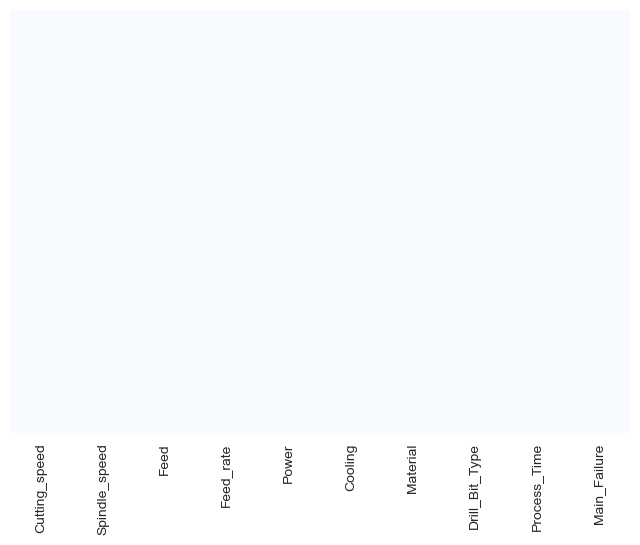

In [11]:
visual_plot. missing_value()

### STATISTICS

In [12]:
# data segmentation
fail_df = Pm_df[Pm_df['Main_Failure'] == 1]
run_df = Pm_df[Pm_df['Main_Failure'] == 0]

In [13]:
# checking for statistics of Main failure group
print('Total = ', len(Pm_df))
print('Number of failed occurence = ', len(fail_df))
print('% of failed occurence =',1.*len(fail_df)/len(Pm_df)*100, '%')

print('Number of successful run = ', len(run_df))
print('% of successful run =', 1.*len(run_df)/len(Pm_df)*100, '%')

Total =  20000
Number of failed occurence =  1001
% of failed occurence = 5.005 %
Number of successful run =  18999
% of successful run = 94.99499999999999 %


In [14]:
fail_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Cutting_speed,1001.0,23.469091,5.143647,16.330,17.51,22.400,29.580,30.670
Spindle_speed,1001.0,622.533467,136.445121,433.000,464.00,594.000,785.000,813.000
Feed,1001.0,0.206116,0.039821,0.108,0.17,0.219,0.233,0.297
Feed_rate,1001.0,151.687313,52.512676,62.000,112.00,133.000,211.000,250.000
Power,1001.0,120.748941,63.041334,49.040,68.69,84.710,191.800,269.060
Cooling,1001.0,43.831169,30.290798,0.000,25.00,50.000,75.000,100.000
Process_Time,1001.0,28.879401,7.039086,16.670,20.22,32.900,34.580,38.570
Main_Failure,1001.0,1.000000,0.000000,1.000,1.00,1.000,1.000,1.000


In [15]:
run_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Cutting_speed,18999.0,23.314744,5.175801,16.700,17.590,22.610,29.810,31.070
Spindle_speed,18999.0,618.439497,137.291425,443.000,467.000,600.000,791.000,824.000
Feed,18999.0,0.225817,0.037181,0.122,0.194,0.235,0.254,0.321
Feed_rate,18999.0,140.047266,40.724471,71.000,109.000,121.000,183.000,261.000
Power,18999.0,129.427124,65.498153,51.990,78.920,93.560,205.065,305.220
Cooling,18999.0,57.430654,23.363764,0.000,50.000,50.000,75.000,100.000
Process_Time,18999.0,29.261298,6.856990,15.970,20.370,32.960,34.530,38.400
Main_Failure,18999.0,0.000000,0.000000,0.000,0.000,0.000,0.000,0.000


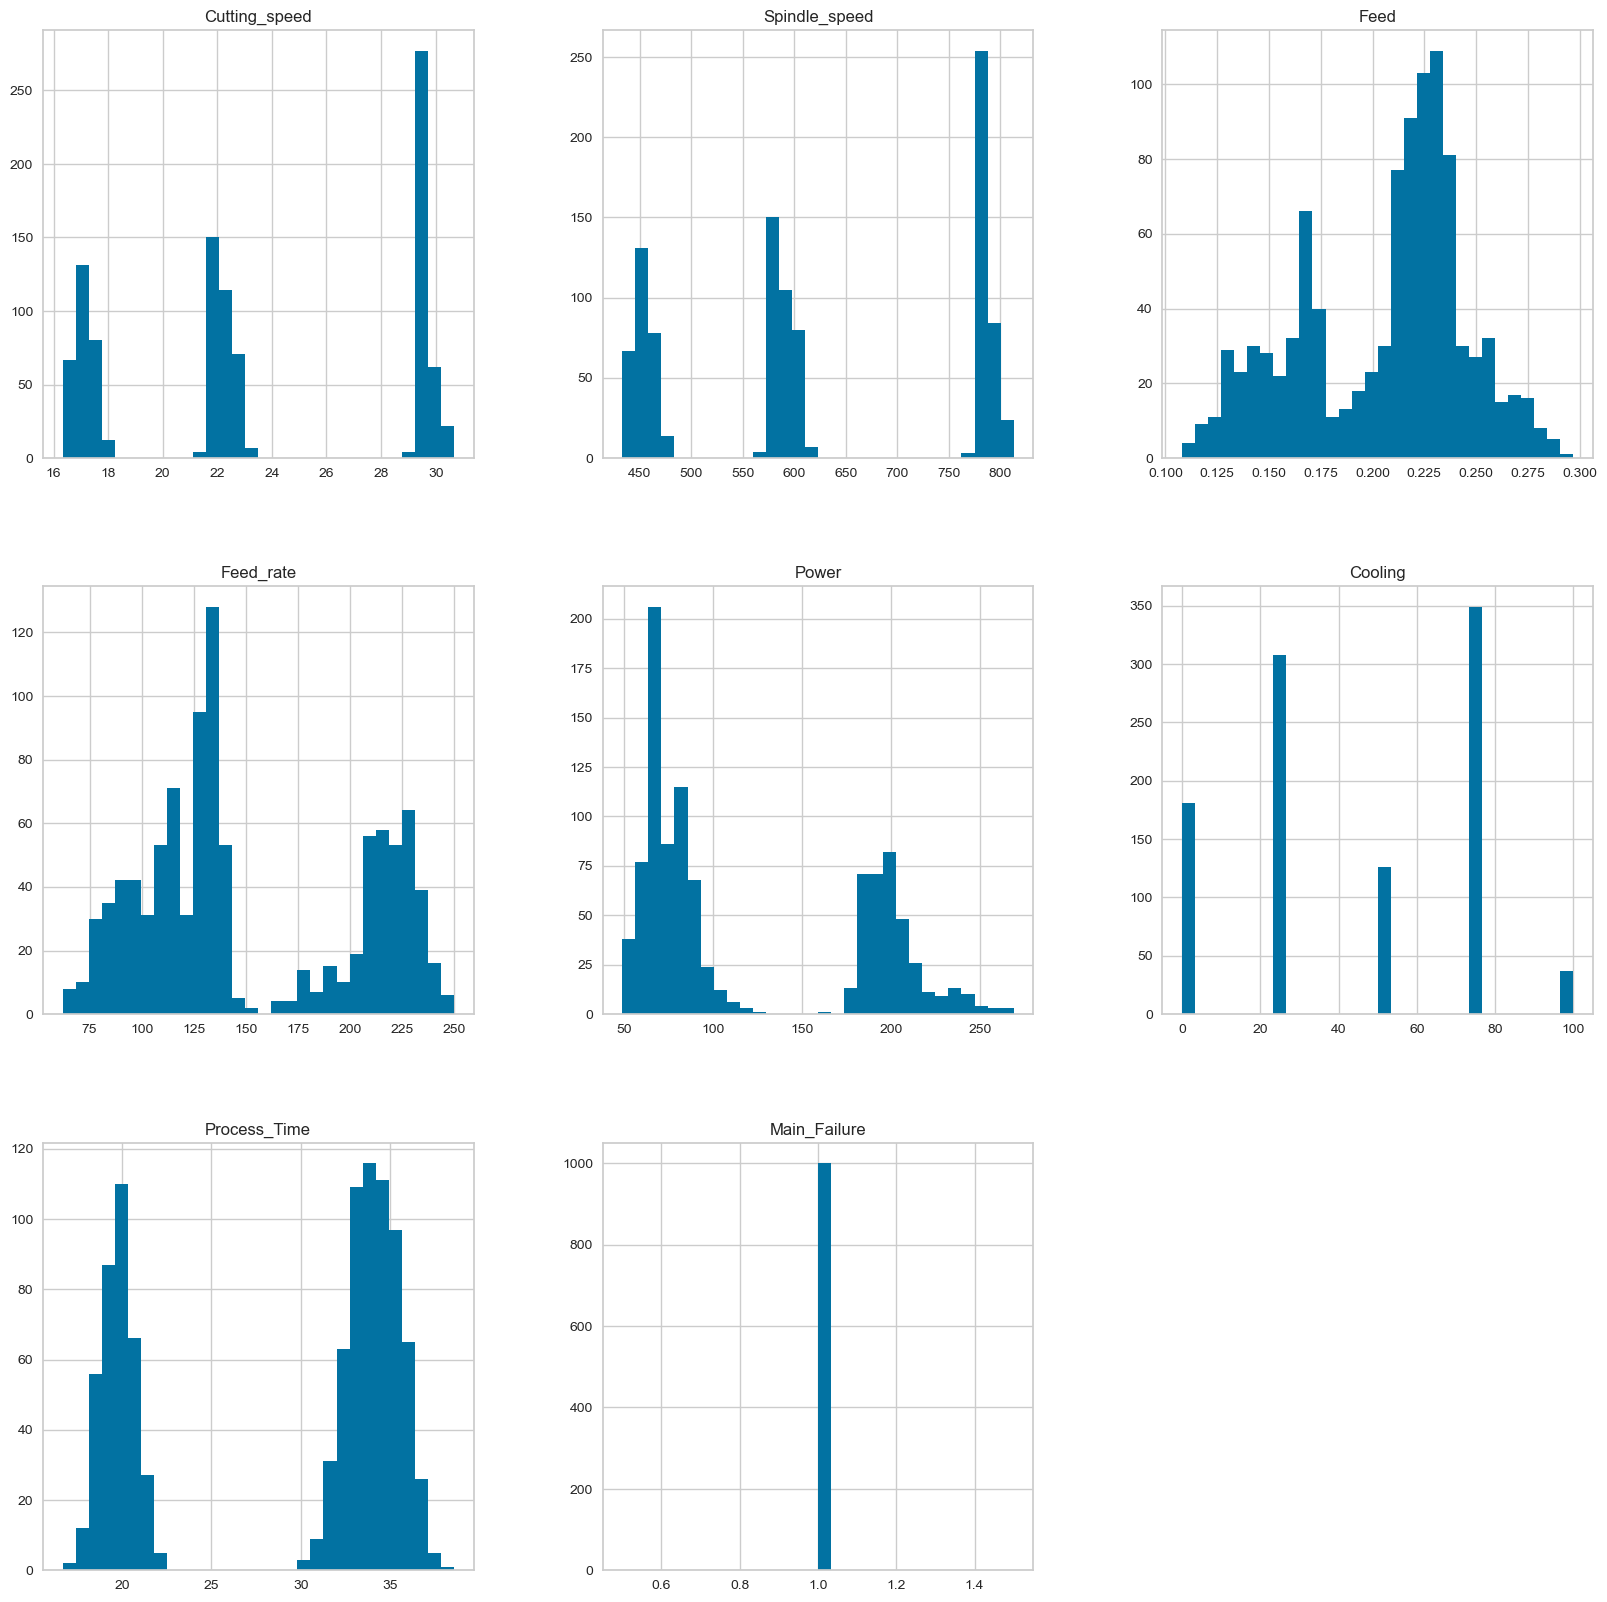

In [16]:
# checking the distribution of variable when the machine failed
fail_df.hist(bins = 30, figsize = (20,20), color = 'b')
plt.title('Distribution of Variable when the Machine Failed')
plt.show()

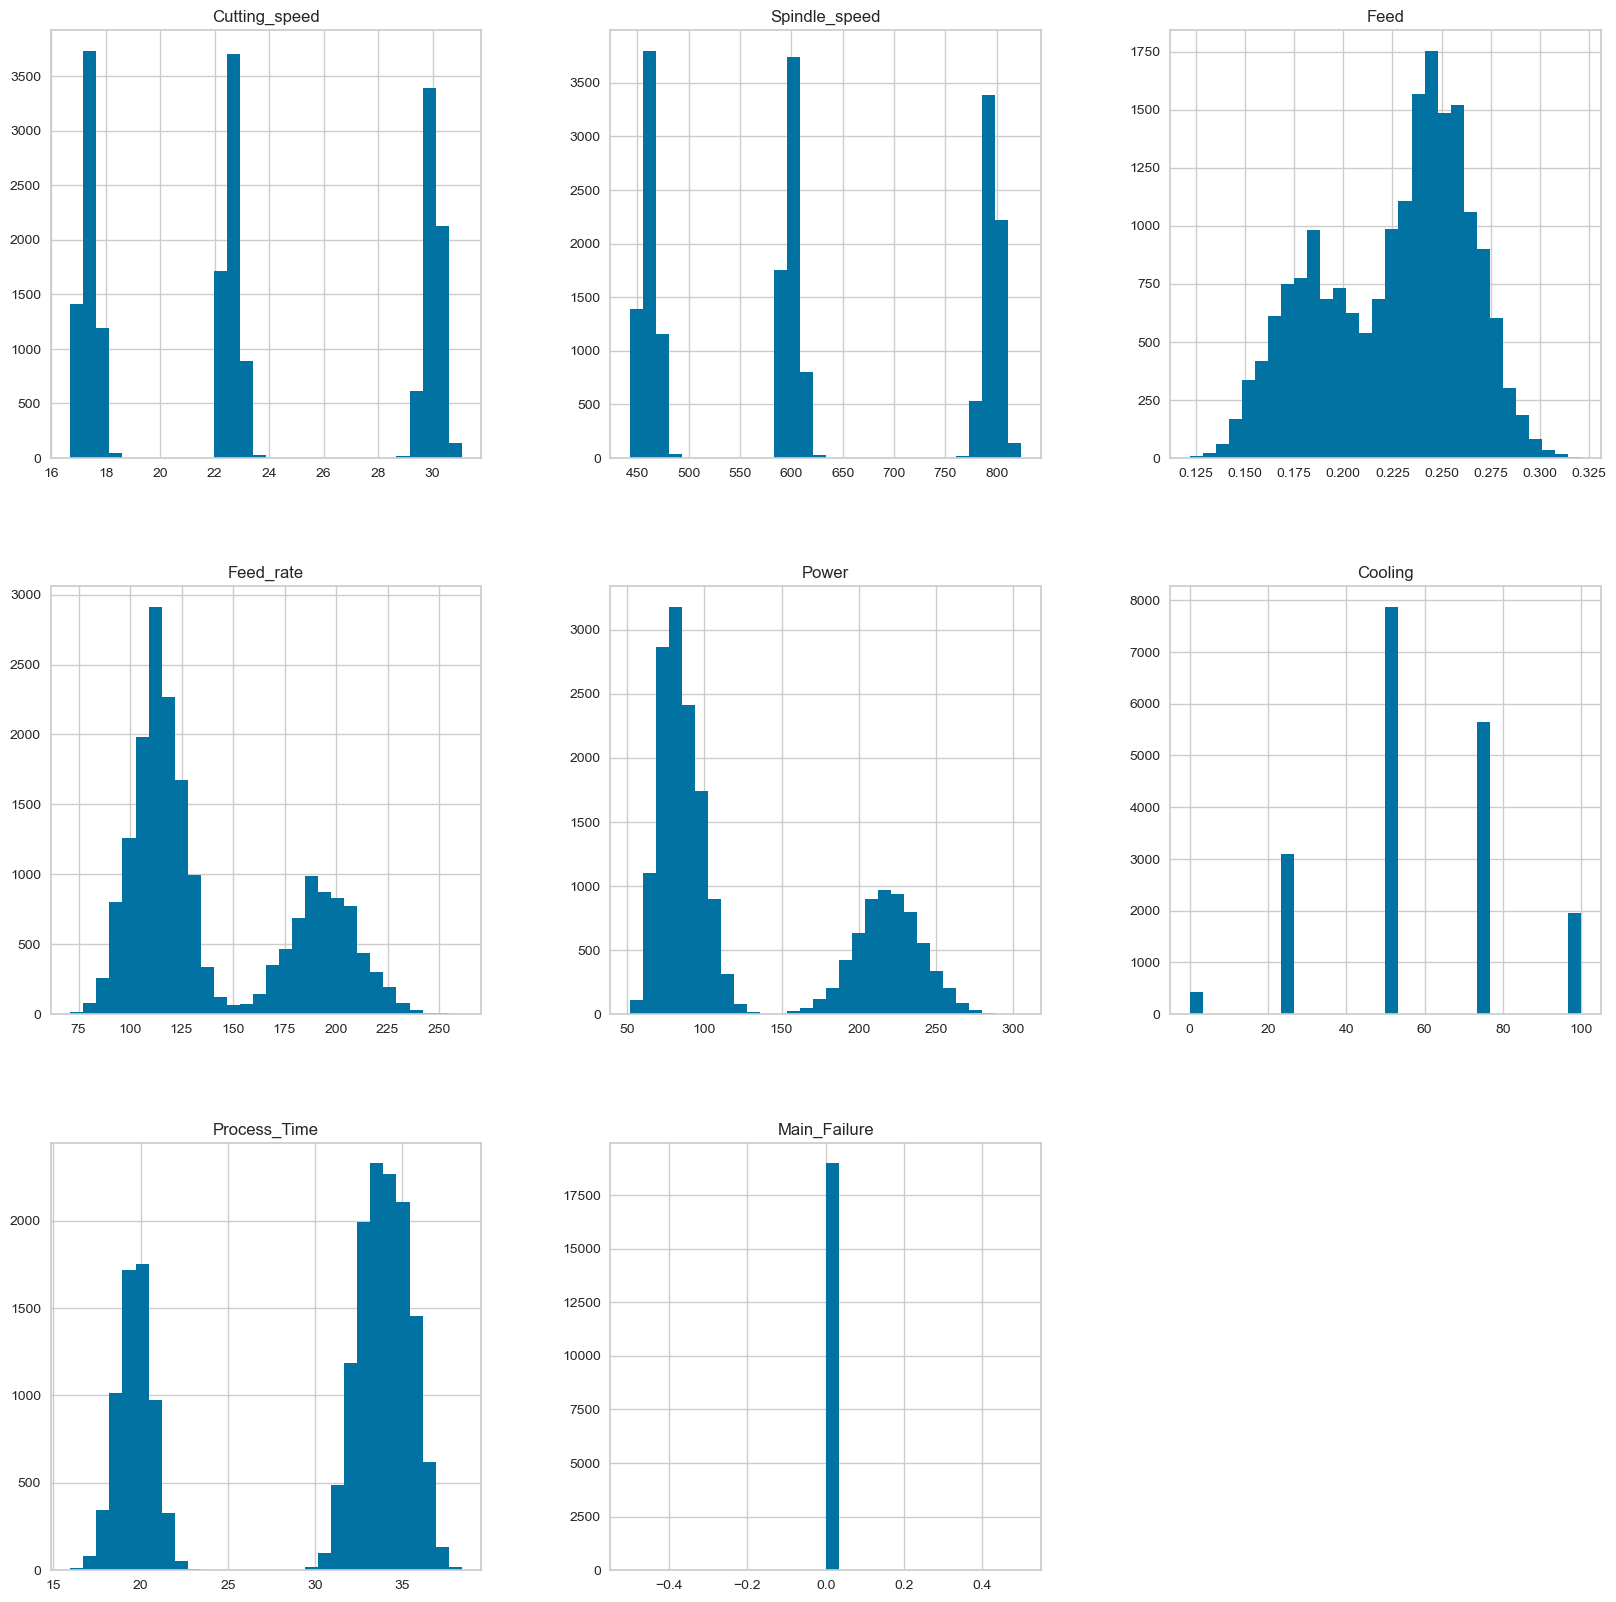

In [17]:
# checking the distribution of variable when the machine is running
run_df.hist(bins = 30, figsize = (20,20), color = 'b')
plt.title('Distribution of Variable when the Machine is Running')
plt.show()

### Kernel Density Estimate plot

In [18]:
class KDEPlotter:
    def __init__(self, fail_df, run_df):
        self.fail_df = fail_df
        self.run_df = run_df
    
    def kdeplot_feature(self, feature, xlabel=None, title=None):
        if feature not in self.fail_df.columns or feature not in self.run_df.columns:
            raise ValueError(f"Feature '{feature}' is not in the DataFrame.")
        
        plt.figure(figsize=(8, 5))
        sns.kdeplot(self.fail_df[feature], label='Machine Failed', shade=True, color='r')
        sns.kdeplot(self.run_df[feature], label='Machine Running', shade=True, color='b')
        
        plt.xlabel(xlabel if xlabel else feature)
        plt.title(title if title else f'Distribution of {feature}')
        plt.legend()
        plt.grid(False)
        plt.show()


kde_plotter = KDEPlotter(fail_df, run_df)

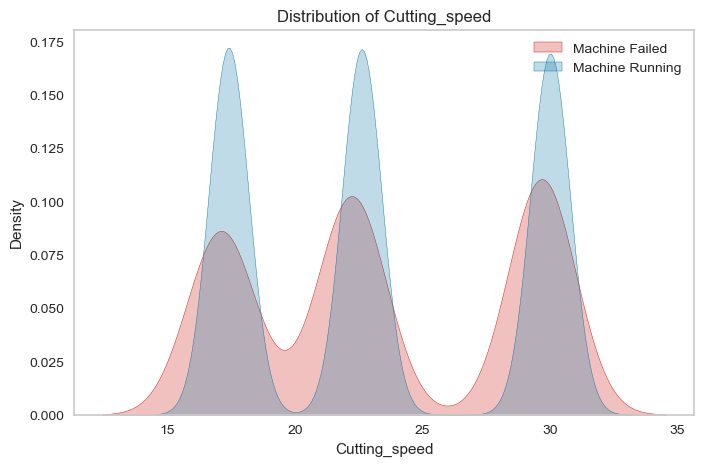

In [19]:
kde_plotter.kdeplot_feature('Cutting_speed')

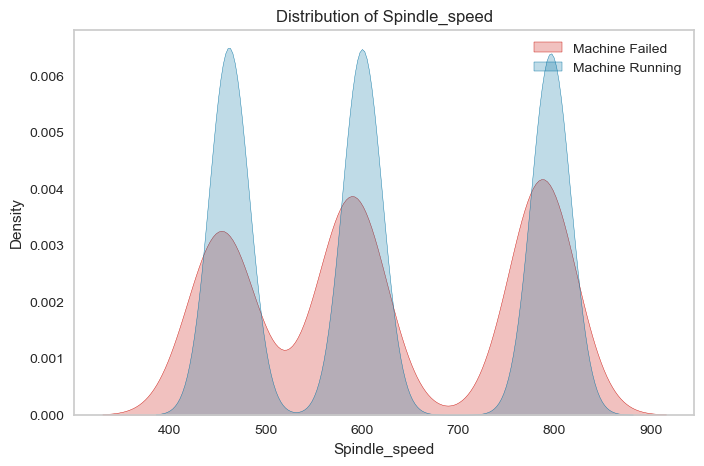

In [20]:
kde_plotter.kdeplot_feature('Spindle_speed')

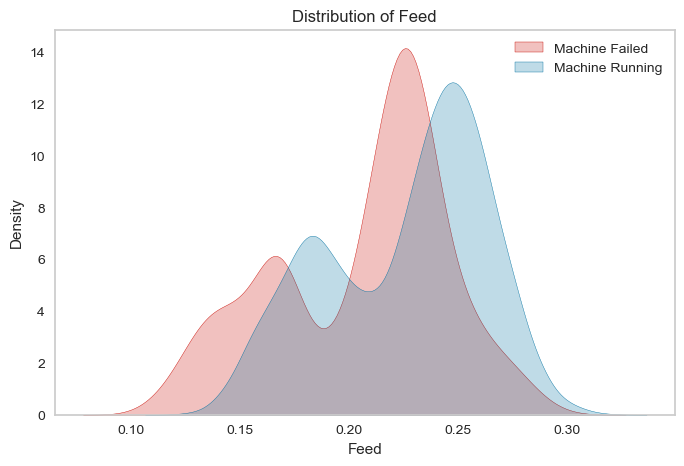

In [21]:
kde_plotter.kdeplot_feature('Feed')

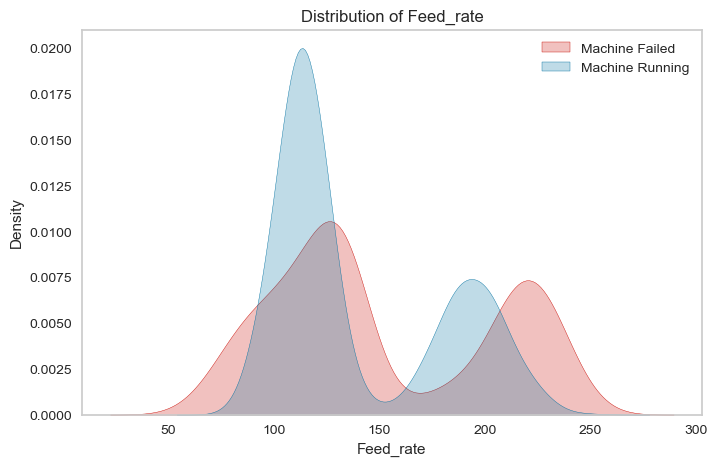

In [22]:
kde_plotter.kdeplot_feature('Feed_rate')

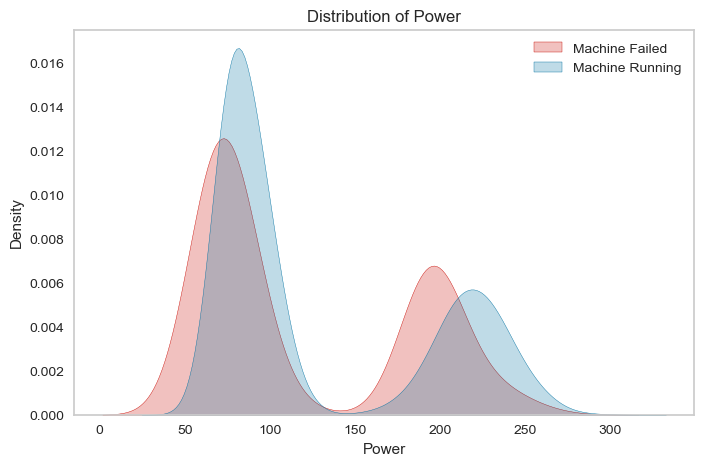

In [23]:
kde_plotter.kdeplot_feature('Power')

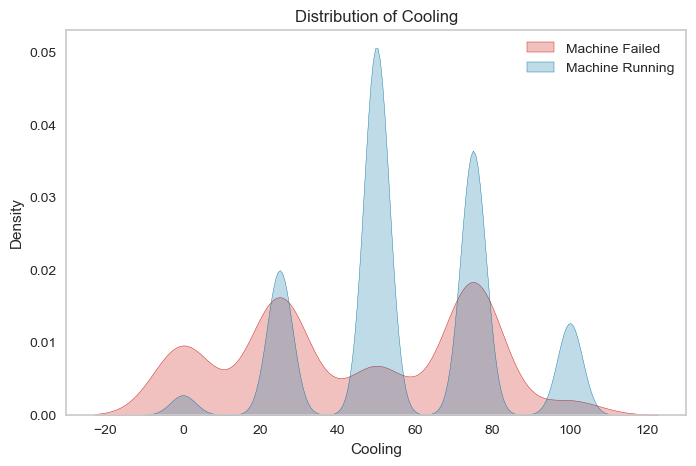

In [24]:
kde_plotter.kdeplot_feature('Cooling')

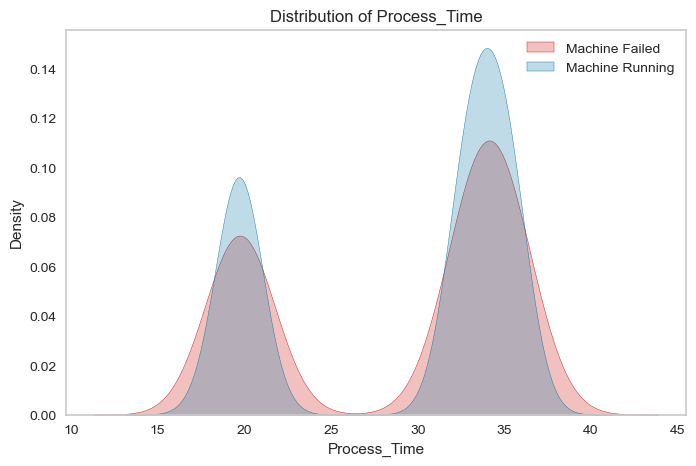

In [25]:
kde_plotter.kdeplot_feature('Process_Time')

## One-Hot-Encoding (Converting Categorical )

In [26]:
# Convert categorical variables to dummy/indicator variables
Pm_df = pd.get_dummies(Pm_df, columns=['Material', 'Drill_Bit_Type'], dtype=np.int64)

In [27]:
Pm_df.dtypes

Cutting_speed       float64
Spindle_speed         int64
Feed                float64
Feed_rate             int64
Power               float64
Cooling               int64
Process_Time        float64
Main_Failure          int64
Material_K            int64
Material_N            int64
Material_P            int64
Drill_Bit_Type_H      int64
Drill_Bit_Type_N      int64
Drill_Bit_Type_W      int64
dtype: object

In [28]:
Pm_df.head()

,Cutting_speed,Spindle_speed,Feed,Feed_rate,Power,Cooling,Process_Time,Main_Failure,Material_K,Material_N,Material_P,Drill_Bit_Type_H,Drill_Bit_Type_N,Drill_Bit_Type_W
0,29.92,794,0.218,173,194.87,75,19.26,0,0,1,0,0,0,1
1,29.85,792,0.241,191,214.71,75,19.55,0,0,1,0,0,0,1
2,22.85,606,0.183,111,95.68,50,36.16,0,0,0,1,0,1,0
3,29.60,785,0.236,237,206.93,75,21.22,1,0,1,0,0,0,1
4,17.43,462,0.246,114,74.85,50,33.56,0,1,0,0,1,0,0


## Correlation

In [29]:
# dataset when machine failed
fail_df = Pm_df[Pm_df['Main_Failure'] == 1]

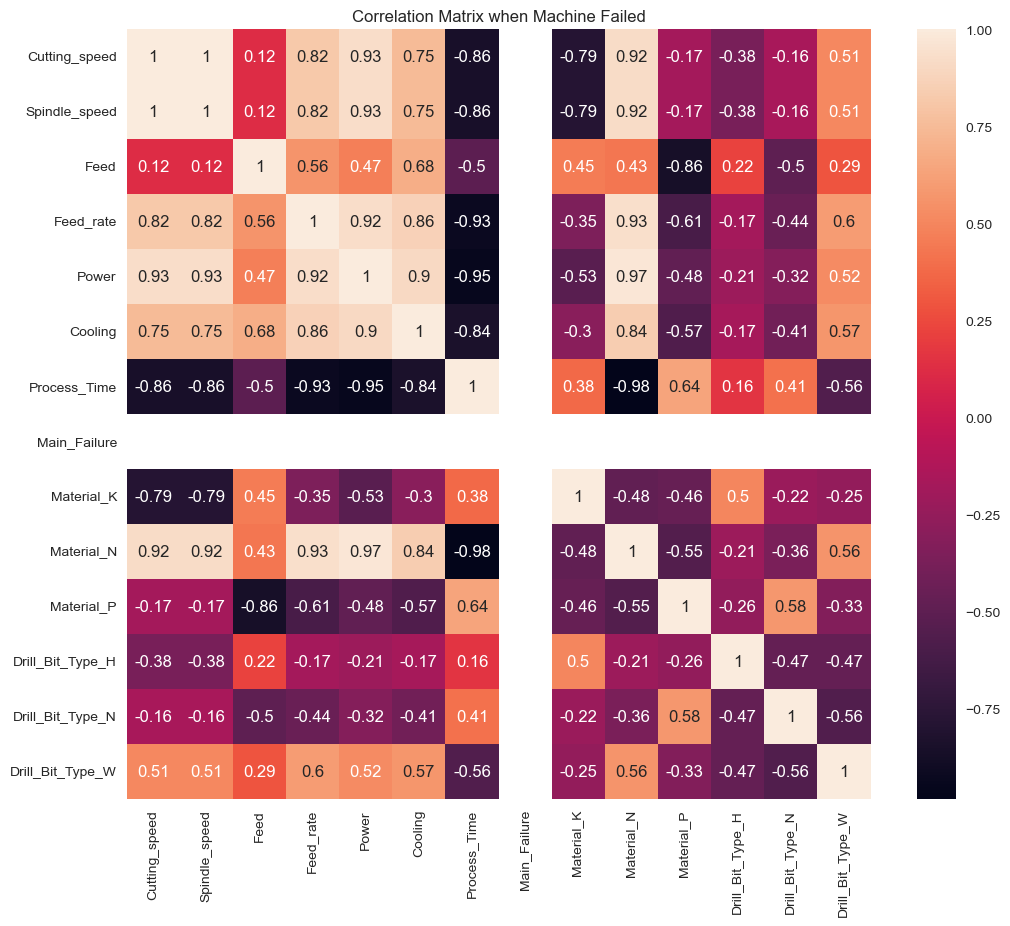

In [30]:
# Checking for correlation between variables when machine is running
def correlation_matrix():
    correlation = fail_df.corr()
    f, ax = plt.subplots(figsize = (12,10))
    sns.heatmap(correlation, annot = True)
    plt.title('Correlation Matrix when Machine Failed')
    plt.grid(False)
    plt.show()
correlation_matrix()

In [31]:
# dataset when machine is running
run_df = Pm_df[Pm_df['Main_Failure'] == 0]

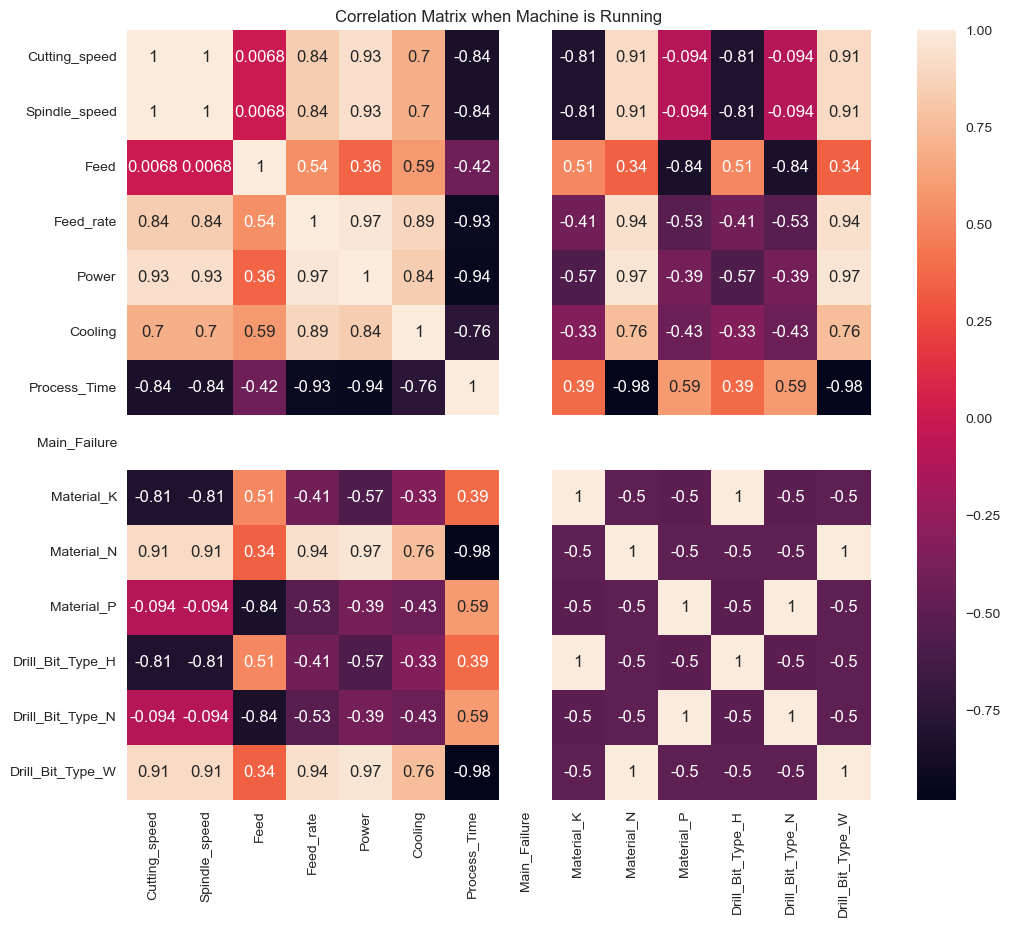

In [32]:
# Checking for correlation between variables when machine is running
def correlation_matrix():
    correlation = run_df.corr()
    f, ax = plt.subplots(figsize = (12,10))
    sns.heatmap(correlation, annot = True)
    plt.title('Correlation Matrix when Machine is Running')
    plt.grid(False)
    plt.show()
correlation_matrix()

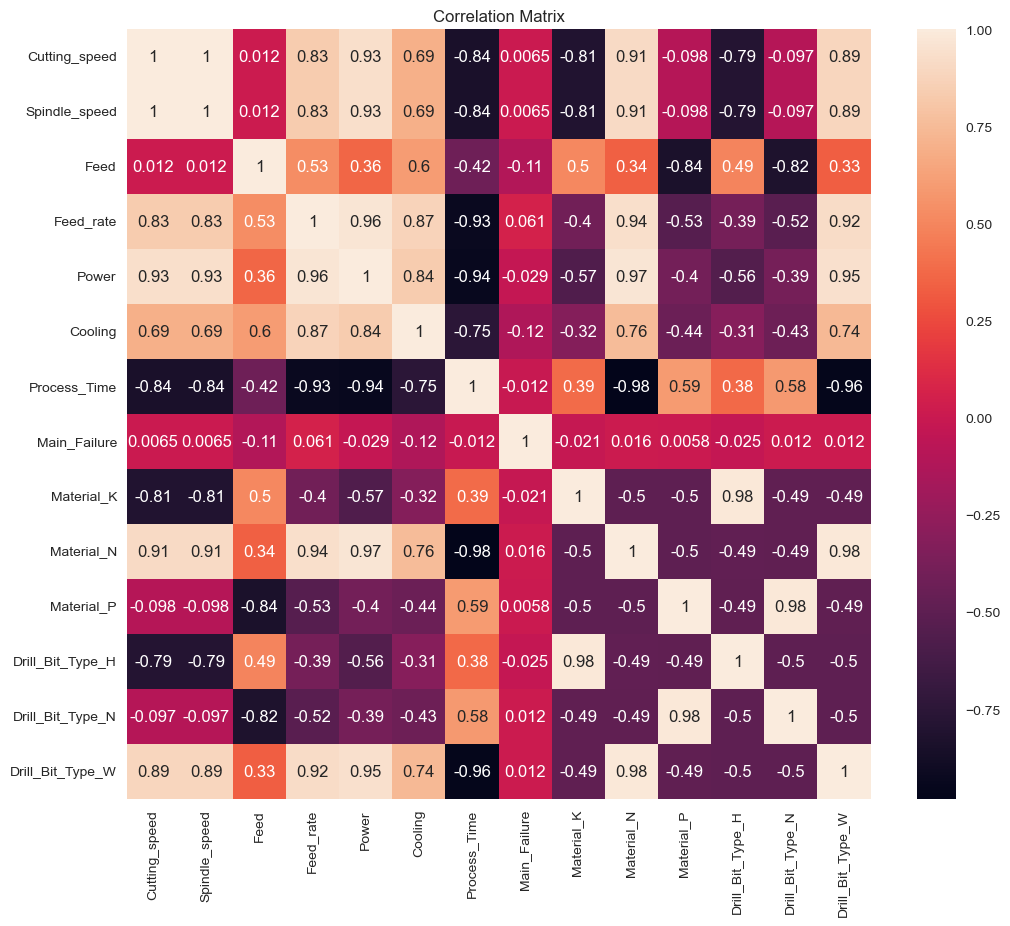

In [33]:
# Checking for correlation between variables using all dataset
def correlation_matrix():
    correlation = Pm_df.corr()
    f, ax = plt.subplots(figsize = (12,10))
    sns.heatmap(correlation, annot = True)
    plt.title('Correlation Matrix')
    plt.show()
correlation_matrix()

In [34]:
# dropping variable not needed for the analysis
Pm_df.drop(["Spindle_speed"], axis =1, inplace= True)

In [35]:
# Spindle speed is dropped because it as a one on one relationship with cutting speed which will not be good for the model

### Feature selection and target assignment

In [36]:
y = Pm_df['Main_Failure']
X = Pm_df.drop(labels=['Main_Failure'], axis=1)

In [37]:
X.head()

,Cutting_speed,Feed,Feed_rate,Power,Cooling,Process_Time,Material_K,Material_N,Material_P,Drill_Bit_Type_H,Drill_Bit_Type_N,Drill_Bit_Type_W
0,29.92,0.218,173,194.87,75,19.26,0,1,0,0,0,1
1,29.85,0.241,191,214.71,75,19.55,0,1,0,0,0,1
2,22.85,0.183,111,95.68,50,36.16,0,0,1,0,1,0
3,29.60,0.236,237,206.93,75,21.22,0,1,0,0,0,1
4,17.43,0.246,114,74.85,50,33.56,1,0,0,1,0,0


In [38]:
y.unique()

array([0, 1], dtype=int64)

In [39]:
X.columns

Index(['Cutting_speed', 'Feed', 'Feed_rate', 'Power', 'Cooling',
       'Process_Time', 'Material_K', 'Material_N', 'Material_P',
       'Drill_Bit_Type_H', 'Drill_Bit_Type_N', 'Drill_Bit_Type_W'],
      dtype='object')

### Separate data into Train and Test

In [40]:
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 42)
X_train.shape, X_test.shape

((14000, 12), (6000, 12))

In [41]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [42]:
# Define feature names
feature_names = ['Cutting_speed', 'Spindle_speed', 'Feed', 'Feed_rate', 'Power',
                  'Cooling', 'Process_Time', 'Material_K', 'Material_N', 'Material_P',
                  'Drill_Bit_Type_H', 'Drill_Bit_Type_N', 'Drill_Bit_Type_W']


### Standardization

In [43]:
# Data Normalisation and Data scaling
scaler = StandardScaler()

In [44]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

#### Imbalance Data Technique

In [45]:
# set up SMOTE
sm = SMOTE(
    sampling_strategy='auto',  # samples only the minority class
    random_state=0,  # for reproducibility
    k_neighbors=5,
    n_jobs=4
)

X_resampled_b, y_resampled_b = sm.fit_resample(X_train, y_train)
X_resampled_b.shape, y_resampled_b.shape

((26638, 12), (26638,))

#### Function

gini Function: To Computes the Gini coefficient for a set of predictions, which is a measure of model performance derived from the AUC.

plot_gini Function: To Plots the ROC curves for training and test sets, annotated with their respective Gini coefficients.

feat_imp Function: To Computes feature importances for an XGBoost model using multiple metrics and returns the most important features.

In [46]:
def gini(y_true, y_pred, sample = None):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    if sample:
        print(f'Gini on {sample} = {100*(2*auc(fpr,tpr)-1):.1f}')
    return 100*(2*auc(fpr,tpr)-1), fpr, tpr

def plot_gini(y_true_train, y_pred_train, y_true_test, y_pred_test):
    fig= plt.figure(figsize=(7,5))
    ax = fig.add_subplot(1,1,1)

    train_gini, fpr_train, tpr_train = gini(y_true_train, y_pred_train)
    test_gini, fpr_test, tpr_test = gini(y_true_test, y_pred_test)
    
    ax.plot(fpr_test, tpr_test, color='green', label='Test (GINI = %0.1f)' % (test_gini))
    ax.plot(fpr_train, tpr_train, color='red', label='Train (GINI = %0.1f)' % (train_gini))
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve', fontsize=16)
    ax.legend(loc="lower right", frameon=False)
    plt.show()  
    
def feat_imp(model, n = None):
    imp_type = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
    df_imp = pd.DataFrame(columns=['type', 'feature', 'importance'])

    for importance in imp_type:
        FI = pd.DataFrame.from_dict(model.get_booster().get_score(importance_type=importance), orient = 'index', columns=['importance']).reset_index().sort_values('importance', ascending = False)
        FI.columns = ['feature', 'importance']
        FI['importance'] = FI['importance']/sum(FI['importance'])
        FI.insert(0,'type',importance)
        df_imp = df_imp.append(FI)
    df_imp = df_imp.pivot(index='feature',columns='type', values='importance')
    df_imp['avg'] = df_imp[imp_type].mean(axis=1)
    if n:
        return df_imp.sort_values('avg', ascending=False).head(n)
    else:
        return df_imp.sort_values('avg', ascending=False)

#### Set up XGBOOST Model

### Original dataset

[0]	validation_0-auc:0.74449
[25]	validation_0-auc:0.99492
[50]	validation_0-auc:0.99502
[75]	validation_0-auc:0.99499
[99]	validation_0-auc:0.99481
Gini on train = 100.0
Gini on test = 99.0


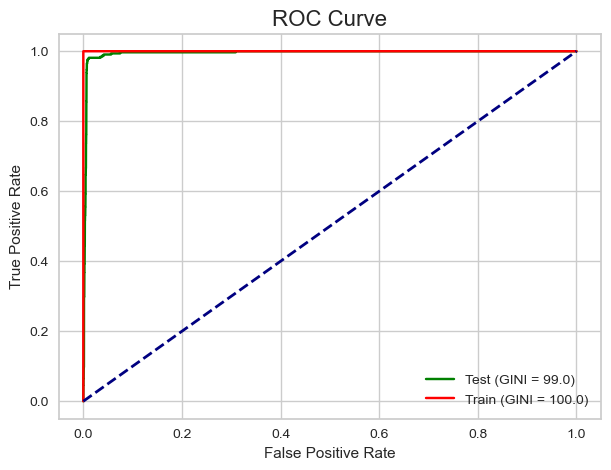

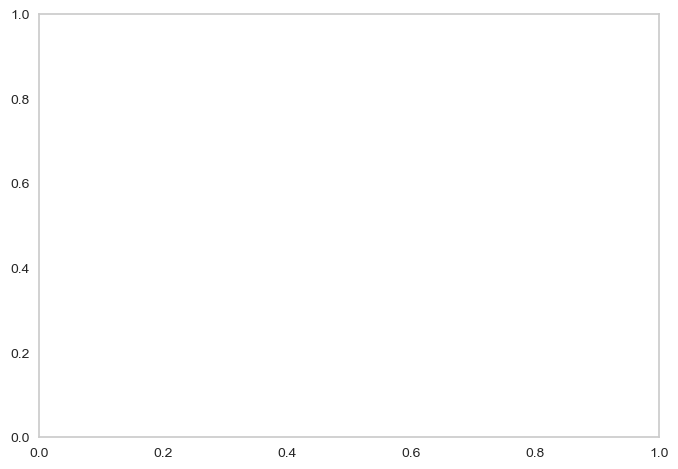

In [47]:
model = XGBClassifier(use_label_encoder=False, eval_metric = 'auc')
model.fit(X_train, y_train, eval_set = [(X_test, y_test)], verbose=25)

train_gini, _, _ = gini(y_train, model.predict_proba(X_train)[:,1], 'train')
test_gini,_ , _ = gini(y_test, model.predict_proba(X_test)[:,1], 'test')

plot_gini(y_train, model.predict_proba(X_train)[:,1], y_test, model.predict_proba(X_test)[:,1])
plt.grid(False)

In [48]:
from sklearn.metrics import ConfusionMatrixDisplay,classification_report

In [49]:
#pred = model.predict(X_test)

In [50]:
sns.reset_orig()

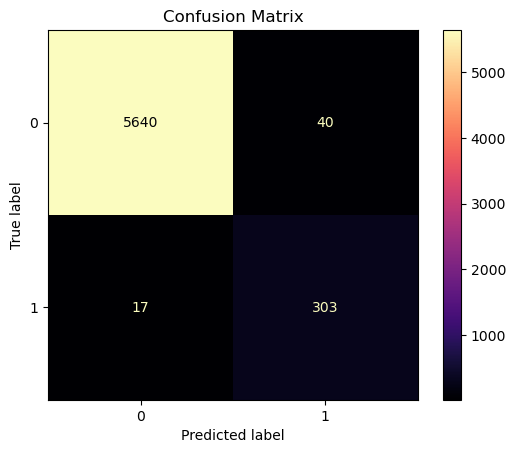

Test Classification Report:
                 precision    recall  f1-score   support

Machine Running       1.00      0.99      0.99      5680
 Machine Failed       0.88      0.95      0.91       320

       accuracy                           0.99      6000
      macro avg       0.94      0.97      0.95      6000
   weighted avg       0.99      0.99      0.99      6000



In [51]:
pred = model.predict(X_test)
ConfusionMatrixDisplay.from_predictions(
            y_test, pred,
            labels = model.classes_,
            cmap = 'magma')

plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print('Test Classification Report:')
print(classification_report(y_test, pred, target_names=['Machine Running', 'Machine Failed']))

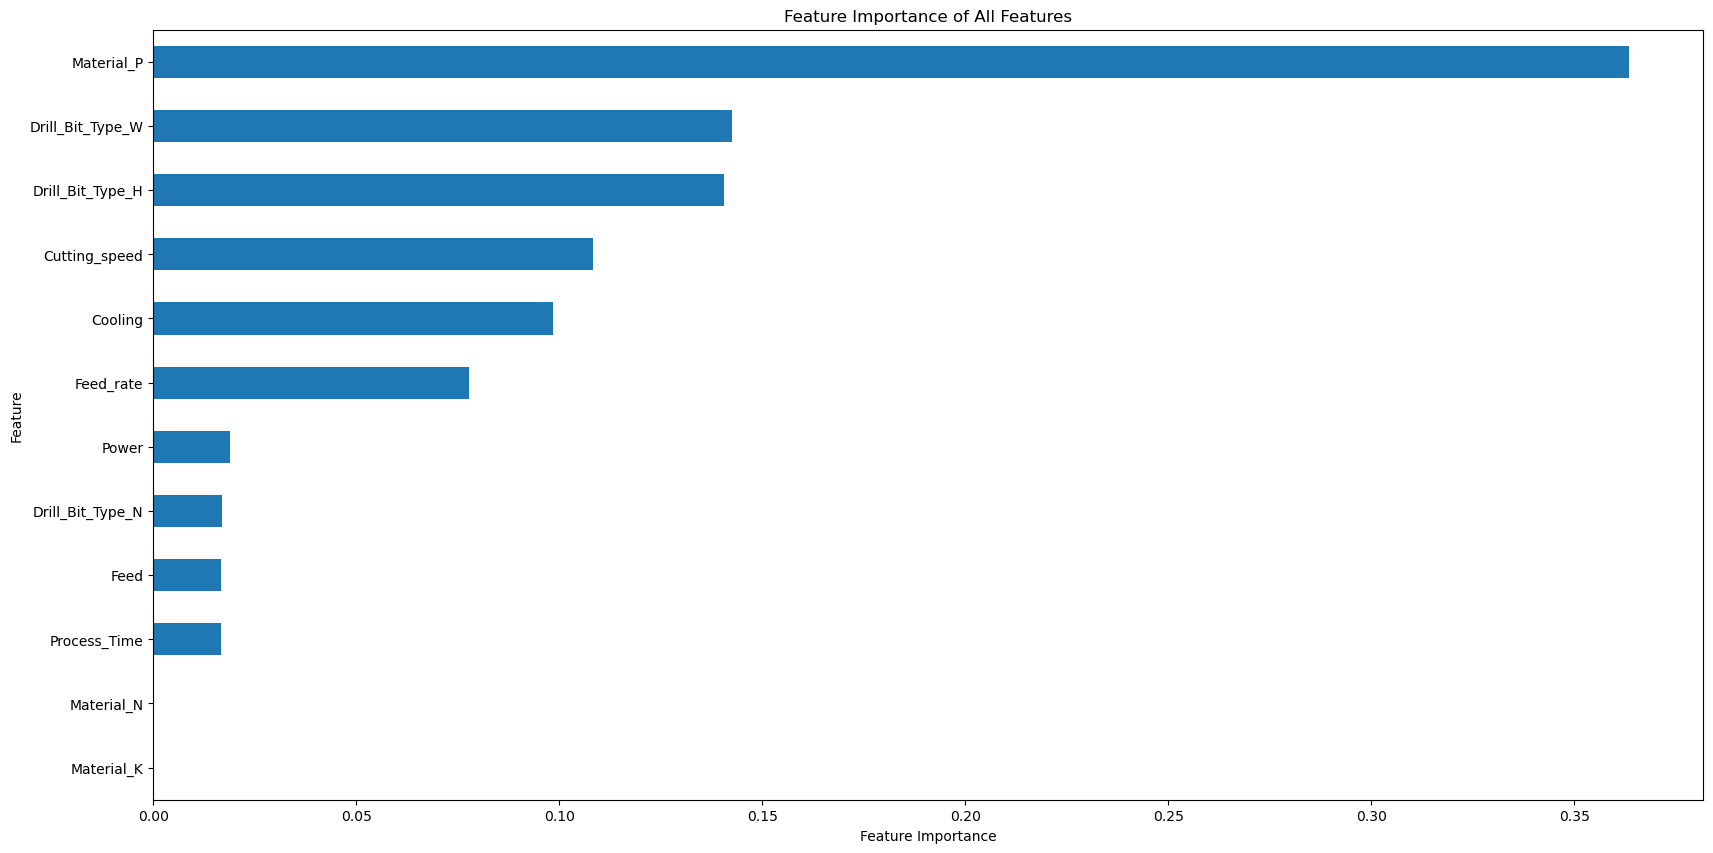

In [52]:
# Extract and sort feature importances
importances = pd.Series(model.feature_importances_, index=['Cutting_speed','Feed', 'Feed_rate', 'Power',
                                                           'Cooling', 'Process_Time', 'Material_K', 'Material_N', 'Material_P',
                                                           'Drill_Bit_Type_H', 'Drill_Bit_Type_N', 'Drill_Bit_Type_W'])
importances = importances.sort_values(ascending=True)

# Plot feature importances
importances.plot(kind='barh', figsize=(20, 10))
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of All Features')
plt.grid(False)  # Disable grid lines
plt.show()

In [53]:
# List of feature names
feature_names = ['Cutting_speed', 'Spindle_speed', 'Feed_rate', 'Power',
                  'Cooling', 'Process_Time', 'Material_K', 'Material_N', 'Material_P',
                  'Drill_Bit_Type_H', 'Drill_Bit_Type_N', 'Drill_Bit_Type_W']

# Calculate permutation importance
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

# Create a DataFrame for permutation importances
perm_feat_imp = pd.DataFrame({
    'feature': feature_names,
    'mean': perm_importance.importances_mean,
    'std': perm_importance.importances_std
})

# Sort by mean importance
perm_feat_imp.sort_values('mean', inplace=True, ascending=False)

# Display the top features
perm_feat_imp.head(14)

,feature,mean,std
9,Drill_Bit_Type_H,0.262850,0.003808
11,Drill_Bit_Type_W,0.259367,0.005528
0,Cutting_speed,0.236250,0.003798
2,Feed_rate,0.138917,0.002761
4,Cooling,0.026800,0.001666
1,Spindle_speed,0.021500,0.001049
5,Process_Time,0.018800,0.001110
3,Power,0.010950,0.001019
6,Material_K,0.000000,0.000000
7,Material_N,0.000000,0.000000


### Using Balanced data from SMOTE

[0]	validation_0-auc:0.93440
[25]	validation_0-auc:0.97468
[50]	validation_0-auc:0.98021
[75]	validation_0-auc:0.98048
[99]	validation_0-auc:0.97988
Gini on train = 100.0
Gini on test = 96.0


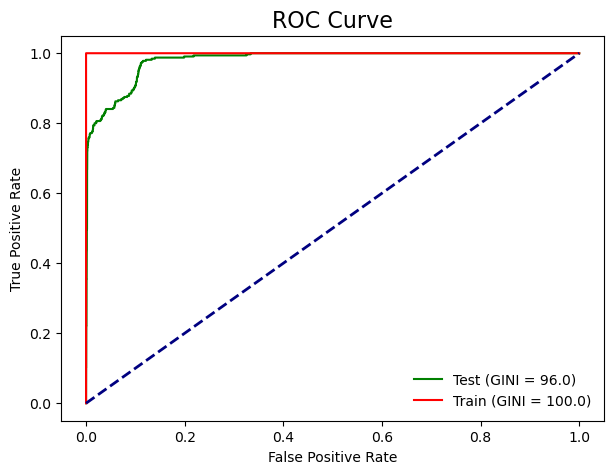

In [54]:
gmodel = XGBClassifier(use_label_encoder=False, eval_metric = 'auc')
gmodel.fit(X_resampled_b, y_resampled_b, eval_set = [(X_test, y_test)], verbose=25)

train_gini, _, _ = gini(y_resampled_b, gmodel.predict_proba(X_resampled_b)[:,1], 'train')
test_gini,_ , _ = gini(y_test, gmodel.predict_proba(X_test)[:,1], 'test')

plot_gini(y_resampled_b, gmodel.predict_proba(X_resampled_b)[:,1], y_test, gmodel.predict_proba(X_test)[:,1])

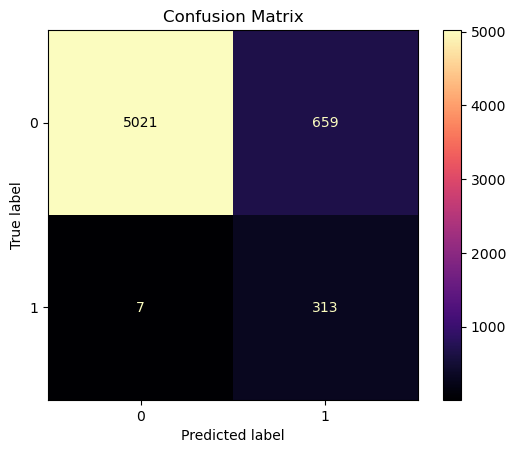

Test Classification Report:
                 precision    recall  f1-score   support

Machine Running       1.00      0.88      0.94      5680
 Machine Failed       0.32      0.98      0.48       320

       accuracy                           0.89      6000
      macro avg       0.66      0.93      0.71      6000
   weighted avg       0.96      0.89      0.91      6000



In [55]:
pred = gmodel.predict(X_test)
ConfusionMatrixDisplay.from_predictions(
            y_test, pred,
            labels = gmodel.classes_,
            cmap = 'magma')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print('Test Classification Report:')
print(classification_report(y_test, pred, target_names=['Machine Running', 'Machine Failed']))

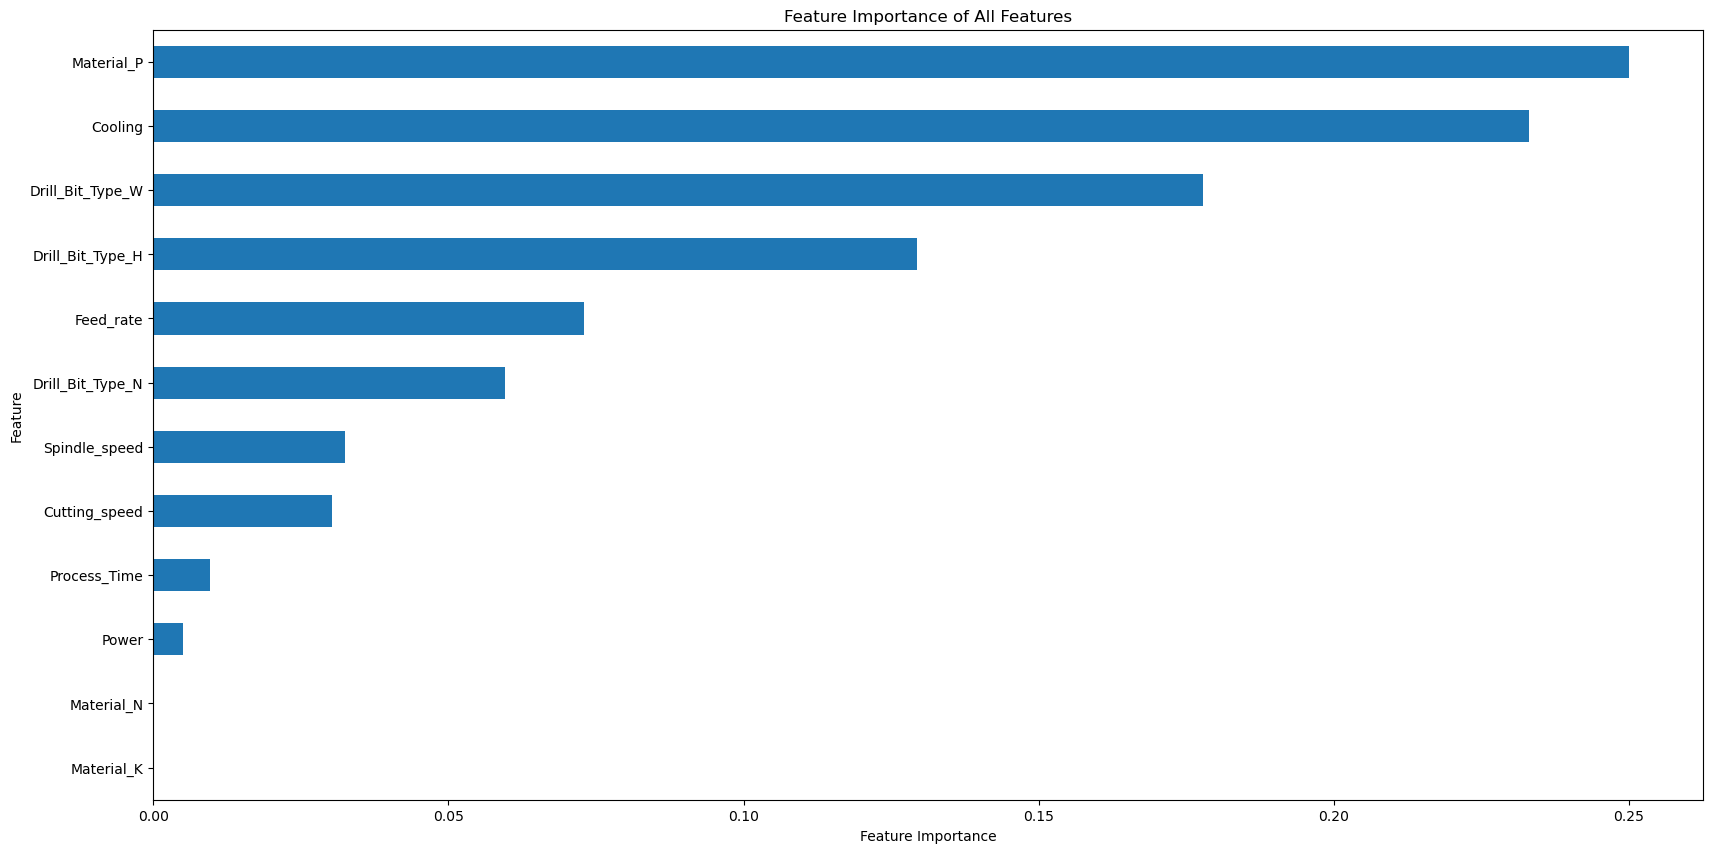

In [56]:
# Extract and sort feature importances
importances = pd.Series(gmodel.feature_importances_, index=['Cutting_speed', 'Spindle_speed', 'Feed_rate', 'Power',
                                                           'Cooling', 'Process_Time', 'Material_K', 'Material_N', 'Material_P',
                                                           'Drill_Bit_Type_H', 'Drill_Bit_Type_N', 'Drill_Bit_Type_W'])
importances = importances.sort_values(ascending=True)

# Plot feature importances
importances.plot(kind='barh', figsize=(20, 10))
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of All Features')
plt.grid(False)  # Disable grid lines
plt.show()

In [57]:
# List of feature names
feature_names = ['Cutting_speed', 'Feed', 'Feed_rate', 'Power',
                  'Cooling', 'Process_Time', 'Material_K', 'Material_N', 'Material_P',
                  'Drill_Bit_Type_H', 'Drill_Bit_Type_N', 'Drill_Bit_Type_W']

# Calculate permutation importance
perm_importance = permutation_importance(gmodel, X_test, y_test, n_repeats=10, random_state=42)

# Create a DataFrame for permutation importances
perm_feat_imp = pd.DataFrame({
    'feature': feature_names,
    'mean': perm_importance.importances_mean,
    'std': perm_importance.importances_std
})

# Sort by mean importance
perm_feat_imp.sort_values('mean', inplace=True, ascending=False)

# Display the top features
perm_feat_imp.head(14)

,feature,mean,std
9,Drill_Bit_Type_H,0.279133,0.004657
11,Drill_Bit_Type_W,0.232183,0.005425
0,Cutting_speed,0.174383,0.005158
2,Feed_rate,0.168517,0.002924
1,Feed,0.069350,0.002525
3,Power,0.060600,0.002360
4,Cooling,0.037483,0.001947
5,Process_Time,0.015817,0.001161
6,Material_K,0.000000,0.000000
7,Material_N,0.000000,0.000000


In [58]:
from sklearn.metrics import confusion_matrix

### Hyperparameter Optimization Using RandomizedSearch

### Original dataset

In [59]:
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

In [60]:
# Define the parameter grid
param_grid = {
    'n_estimators': stats.randint(100, 300),
    'learning_rate': stats.uniform(0.01, 0.3),
    'max_depth': stats.randint(1, 10),
    'subsample': stats.uniform(0.5, 1),
    'colsample_bytree': stats.uniform(0.5, 1),
    'gamma': stats.uniform(0, 5),
    'reg_alpha': stats.uniform(0, 1),
    'reg_lambda': stats.uniform(0, 1),
    'min_child_weight': stats.randint(1, 5),
    'booster': ['gbtree', 'dart'],
    'colsample_bylevel': stats.uniform(0.5, 0.5),  # Uniform distribution between 0.5 and 
    'scale_pos_weight': stats.uniform(0.5, 2),  # Used to control the balance of positive and negative weights
    'sampling_method': ['uniform', 'gradient_based'],  # Method of sampling used for training
    'tree_method': ['auto', 'exact', 'approx', 'hist'],  # Different algorithms to choose for tree building
    'monotone_constraints': [(0, 1), (-1, 0), None]
}

In [61]:
# Set up the search
search = RandomizedSearchCV(model,
                            param_grid,
                            scoring='roc_auc',
                            cv=5,
                            n_iter=60,
                            random_state=42,
                            n_jobs=1,
                            refit=True)

In [62]:
# Find best hyperparameters
search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rat...
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002503CB69650>,
                                        'sampling_method': ['uniform',
                                                            'gradient_based'],
                                        'scale_pos_weight': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000025021EAE5D0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002503CB78F10>,
                                        'tree_method': ['auto', 'exact',
                                                        'approx', 'hist']},
                   random_state=42, scoring='roc_auc')

In [63]:
best_model = search.best_estimator_

Gini on train = 100.0
Gini on test = 98.0


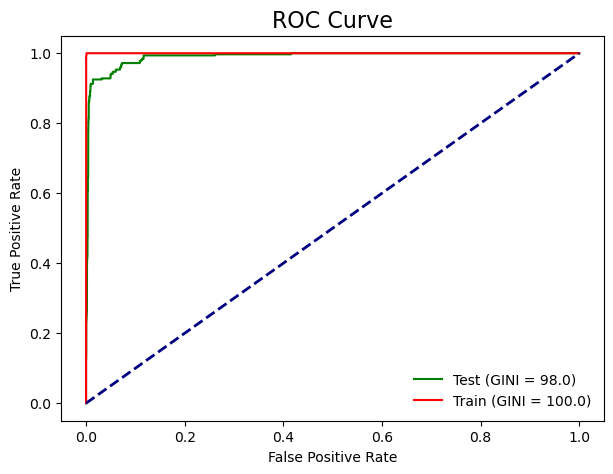

In [64]:
train_gini, _, _ = gini(y_train, best_model.predict_proba(X_train)[:,1], 'train')
test_gini,_ , _ = gini(y_test, best_model.predict_proba(X_test)[:,1], 'test')

plot_gini(y_train, best_model.predict_proba(X_train)[:,1], y_test, best_model.predict_proba(X_test)[:,1])

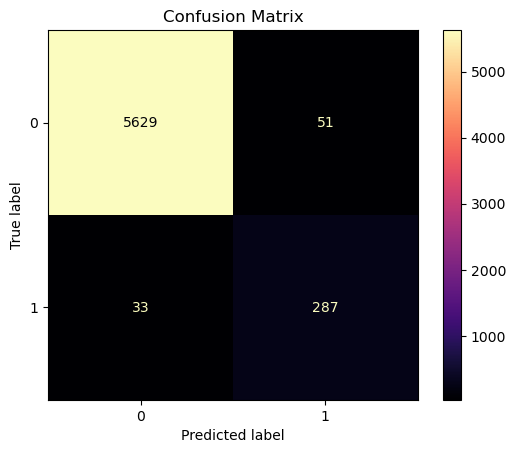

Test Classification Report:
                 precision    recall  f1-score   support

Machine Running       0.99      0.99      0.99      5680
 Machine Failed       0.85      0.90      0.87       320

       accuracy                           0.99      6000
      macro avg       0.92      0.94      0.93      6000
   weighted avg       0.99      0.99      0.99      6000



In [65]:
pred = best_model.predict(X_test)
ConfusionMatrixDisplay.from_predictions(
            y_test, pred,
            labels = best_model.classes_,
            cmap = 'magma')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print('Test Classification Report:')
print(classification_report(y_test, pred, target_names=['Machine Running', 'Machine Failed']))

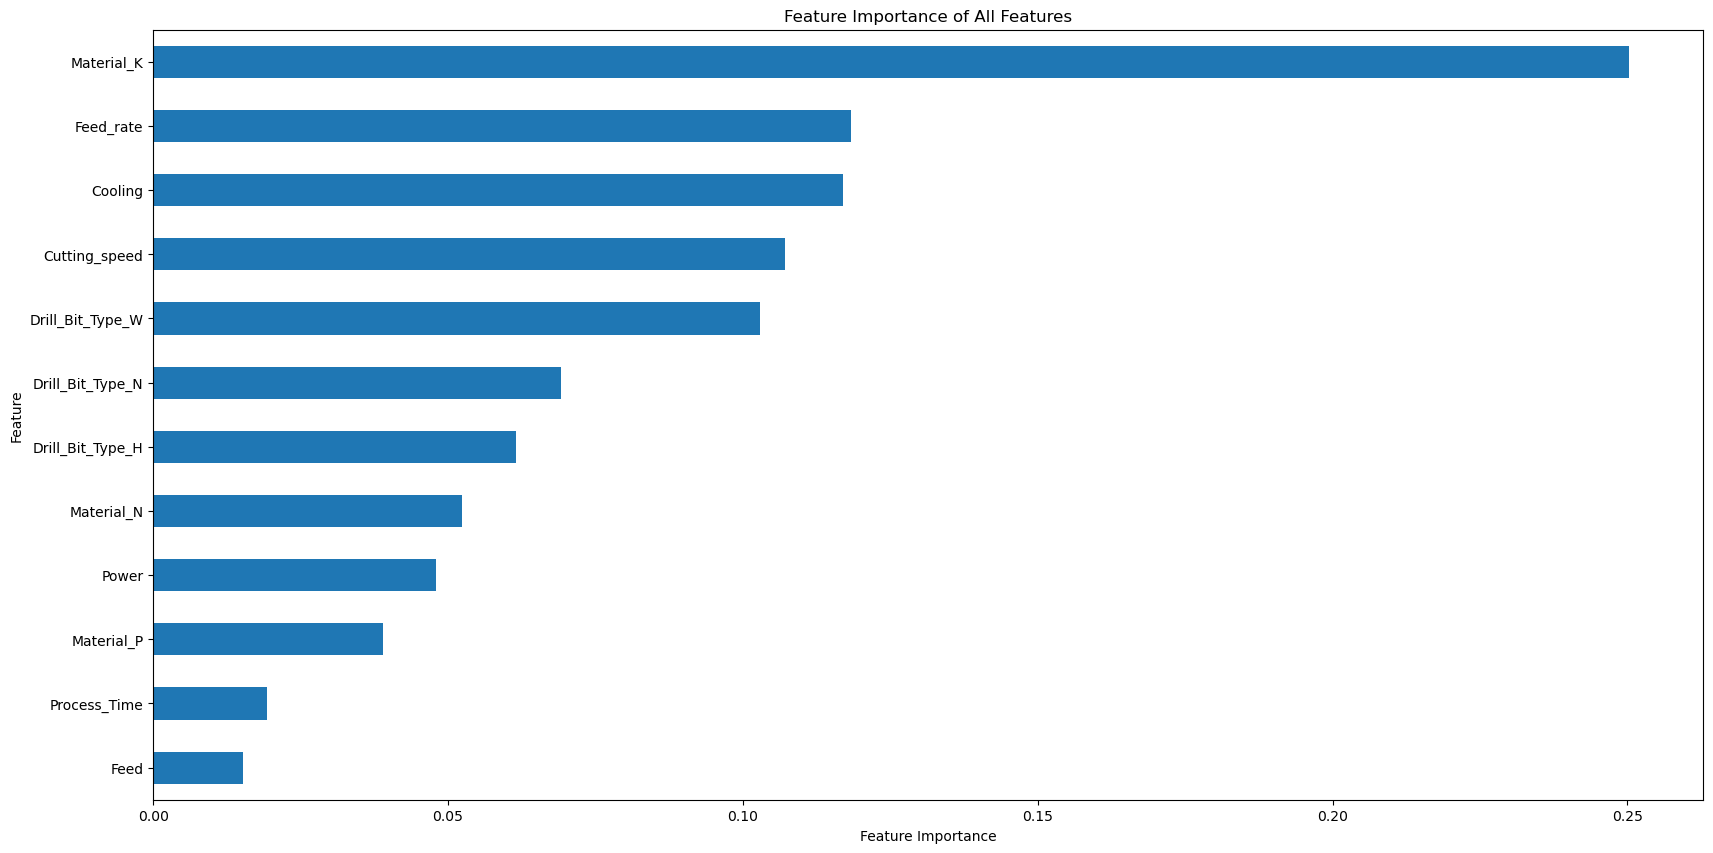

In [66]:
# Extract and sort feature importances
importances = pd.Series(best_model.feature_importances_, index=['Cutting_speed', 'Feed', 'Feed_rate', 'Power',
                                                           'Cooling', 'Process_Time', 'Material_K', 'Material_N', 'Material_P',
                                                           'Drill_Bit_Type_H', 'Drill_Bit_Type_N', 'Drill_Bit_Type_W'])
importances = importances.sort_values(ascending=True)

# Plot feature importances
importances.plot(kind='barh', figsize=(20, 10))
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of All Features')
plt.grid(False)  # Disable grid lines
plt.show()

In [67]:
# List of feature names
feature_names = ['Cutting_speed', 'Spindle_speed', 'Feed_rate', 'Power',
                  'Cooling', 'Process_Time', 'Material_K', 'Material_N', 'Material_P',
                  'Drill_Bit_Type_H', 'Drill_Bit_Type_N', 'Drill_Bit_Type_W']

# Calculate permutation importance
perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)

# Create a DataFrame for permutation importances
perm_feat_imp = pd.DataFrame({
    'feature': feature_names,
    'mean': perm_importance.importances_mean,
    'std': perm_importance.importances_std
})

# Sort by mean importance
perm_feat_imp.sort_values('mean', inplace=True, ascending=False)

# Display the top features
perm_feat_imp.head(14)

,feature,mean,std
9,Drill_Bit_Type_H,0.211067,0.002878
2,Feed_rate,0.148833,0.002781
11,Drill_Bit_Type_W,0.134350,0.004203
0,Cutting_speed,0.071117,0.002230
4,Cooling,0.020817,0.001490
5,Process_Time,0.015917,0.001116
6,Material_K,0.004250,0.000473
3,Power,0.001117,0.000727
1,Spindle_speed,0.000133,0.000067
8,Material_P,0.000000,0.000000


### Balanced Dataset

In [68]:
# Set up the search
Bsearch = search = RandomizedSearchCV(gmodel,
                            param_grid,
                            scoring='roc_auc',
                            cv=5,
                            n_iter=30,
                            random_state=42,
                            n_jobs=1,
                            refit=True)

In [69]:
# Find best hyperparameters
Bsearch.fit(X_resampled_b, y_resampled_b)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rat...
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002503CB69650>,
                                        'sampling_method': ['uniform',
                                                            'gradient_based'],
                                        'scale_pos_weight': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000025021EAE5D0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002503CB78F10>,
                                        'tree_method': ['auto', 'exact',
                                                        'approx', 'hist']},
                   random_state=42, scoring='roc_auc')

In [70]:
# best model
best_model = Bsearch.best_estimator_

Gini on train = 100.0
Gini on test = 99.2


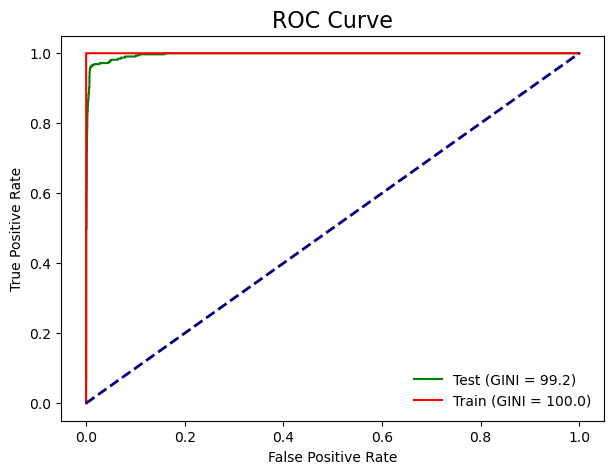

In [71]:
train_gini, _, _ = gini(y_train, best_model.predict_proba(X_train)[:,1], 'train')
test_gini,_ , _ = gini(y_test, best_model.predict_proba(X_test)[:,1], 'test')

plot_gini(y_train, best_model.predict_proba(X_train)[:,1], y_test, best_model.predict_proba(X_test)[:,1])

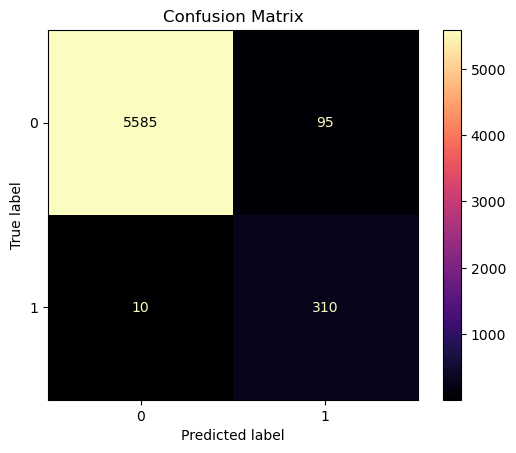

Test Classification Report:
                 precision    recall  f1-score   support

Machine Running       1.00      0.98      0.99      5680
 Machine Failed       0.77      0.97      0.86       320

       accuracy                           0.98      6000
      macro avg       0.88      0.98      0.92      6000
   weighted avg       0.99      0.98      0.98      6000



In [72]:
pred = best_model.predict(X_test)
ConfusionMatrixDisplay.from_predictions(
            y_test, pred,
            labels = best_model.classes_,
            cmap = 'magma')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print('Test Classification Report:')
print(classification_report(y_test, pred, target_names=['Machine Running', 'Machine Failed']))

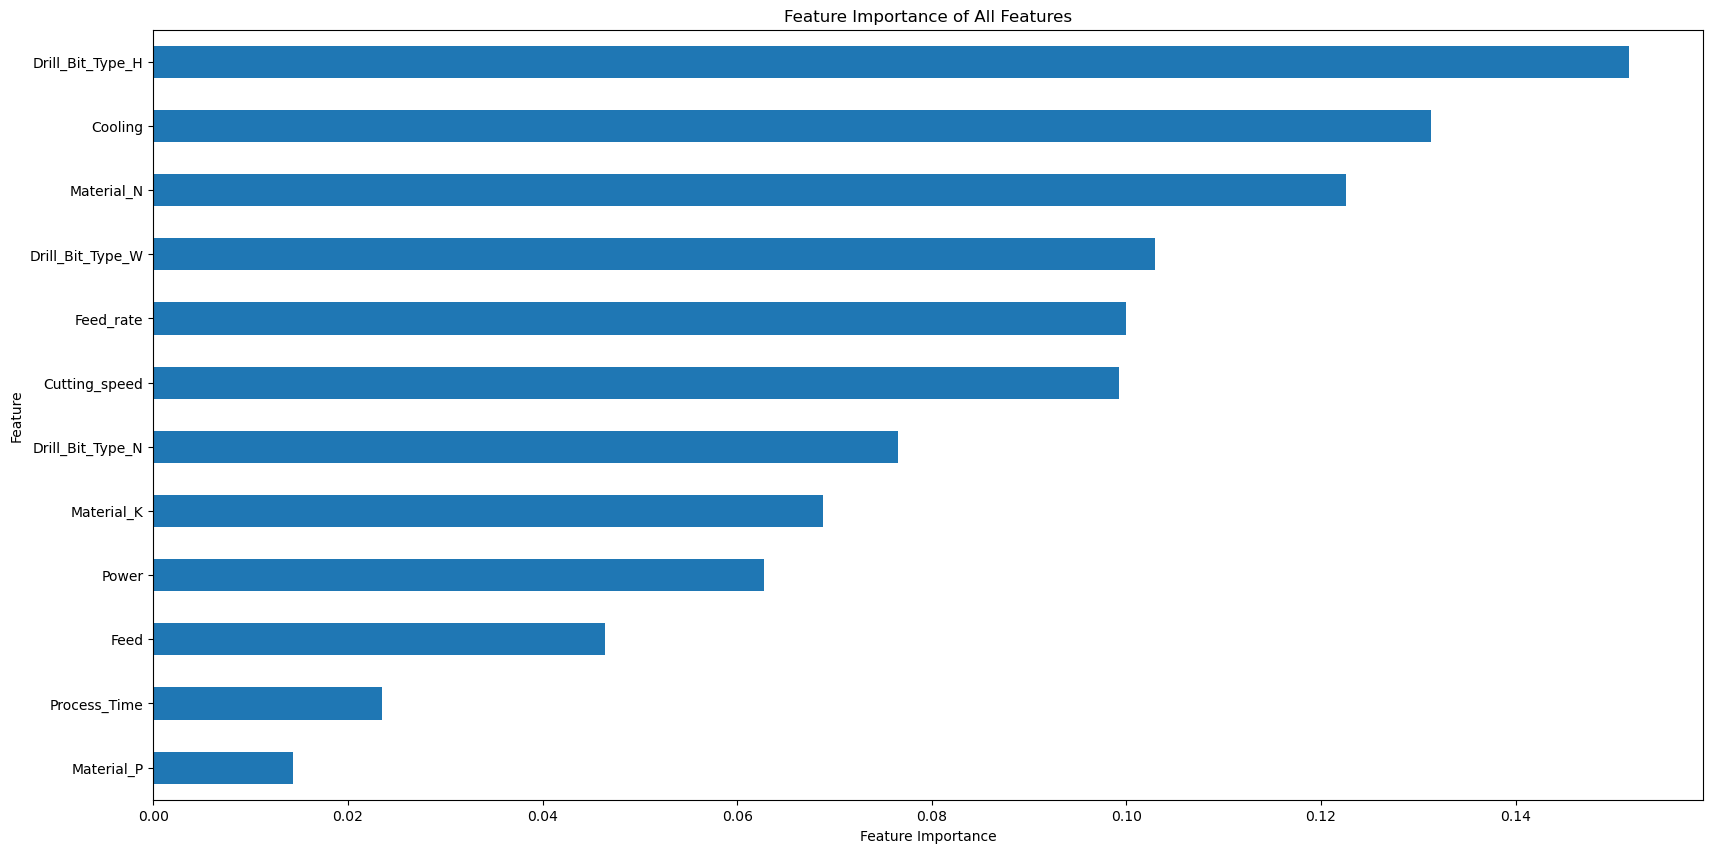

In [73]:
# Extract and sort feature importances
importances = pd.Series(best_model.feature_importances_, index=['Cutting_speed', 'Feed', 'Feed_rate', 'Power',
                                                           'Cooling', 'Process_Time', 'Material_K', 'Material_N', 'Material_P',
                                                           'Drill_Bit_Type_H', 'Drill_Bit_Type_N', 'Drill_Bit_Type_W'])
importances = importances.sort_values(ascending=True)

# Plot feature importances
importances.plot(kind='barh', figsize=(20, 10))
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of All Features')
plt.grid(False)  # Disable grid lines
plt.show()

In [74]:
# List of feature names
feature_names = ['Cutting_speed', 'Feed', 'Feed_rate', 'Power',
                  'Cooling', 'Process_Time', 'Material_K', 'Material_N', 'Material_P',
                  'Drill_Bit_Type_H', 'Drill_Bit_Type_N', 'Drill_Bit_Type_W']

# Calculate permutation importance
perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)

# Create a DataFrame for permutation importances
perm_feat_imp = pd.DataFrame({
    'feature': feature_names,
    'mean': perm_importance.importances_mean,
    'std': perm_importance.importances_std
})

# Sort by mean importance
perm_feat_imp.sort_values('mean', inplace=True, ascending=False)

# Display the top features
perm_feat_imp.head(14)

,feature,mean,std
11,Drill_Bit_Type_W,0.362917,0.007108
2,Feed_rate,0.217450,0.002633
0,Cutting_speed,0.187567,0.003849
9,Drill_Bit_Type_H,0.178600,0.002862
3,Power,0.063833,0.001903
4,Cooling,0.022550,0.001893
7,Material_N,0.017883,0.001333
1,Feed,0.017250,0.001560
8,Material_P,0.000000,0.000000
10,Drill_Bit_Type_N,0.000000,0.000000


### Random Forest

### Original dataset

In [75]:
from sklearn.ensemble import RandomForestClassifier

Gini on train = 100.0
Gini on test = 99.8


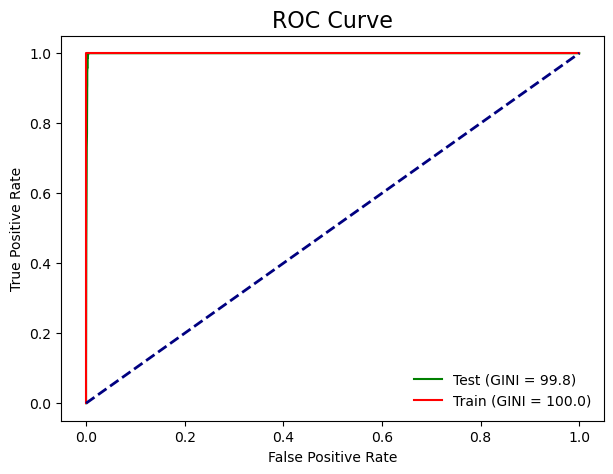

In [76]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42, n_estimators=100)  # Adjust parameters as needed
rf.fit(X_train, y_train)

# Compute the Gini coefficients
train_gini, _, _ = gini(y_train, rf.predict_proba(X_train)[:,1], 'train')
test_gini, _, _ = gini(y_test, rf.predict_proba(X_test)[:,1], 'test')

# Plot the Gini coefficients
plot_gini(y_train, rf.predict_proba(X_train)[:,1], y_test, rf.predict_proba(X_test)[:,1])

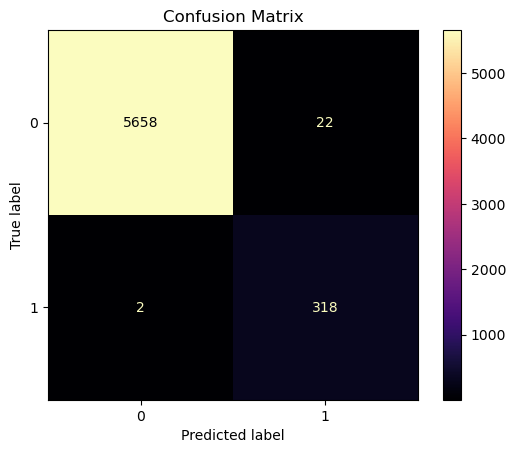

Test Classification Report:
                 precision    recall  f1-score   support

Machine Running       1.00      1.00      1.00      5680
 Machine Failed       0.94      0.99      0.96       320

       accuracy                           1.00      6000
      macro avg       0.97      0.99      0.98      6000
   weighted avg       1.00      1.00      1.00      6000



In [77]:
pred = rf.predict(X_test)
ConfusionMatrixDisplay.from_predictions(
            y_test, pred,
            labels = rf.classes_,
            cmap = 'magma')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print('Test Classification Report:')
print(classification_report(y_test, pred, target_names=['Machine Running', 'Machine Failed']))

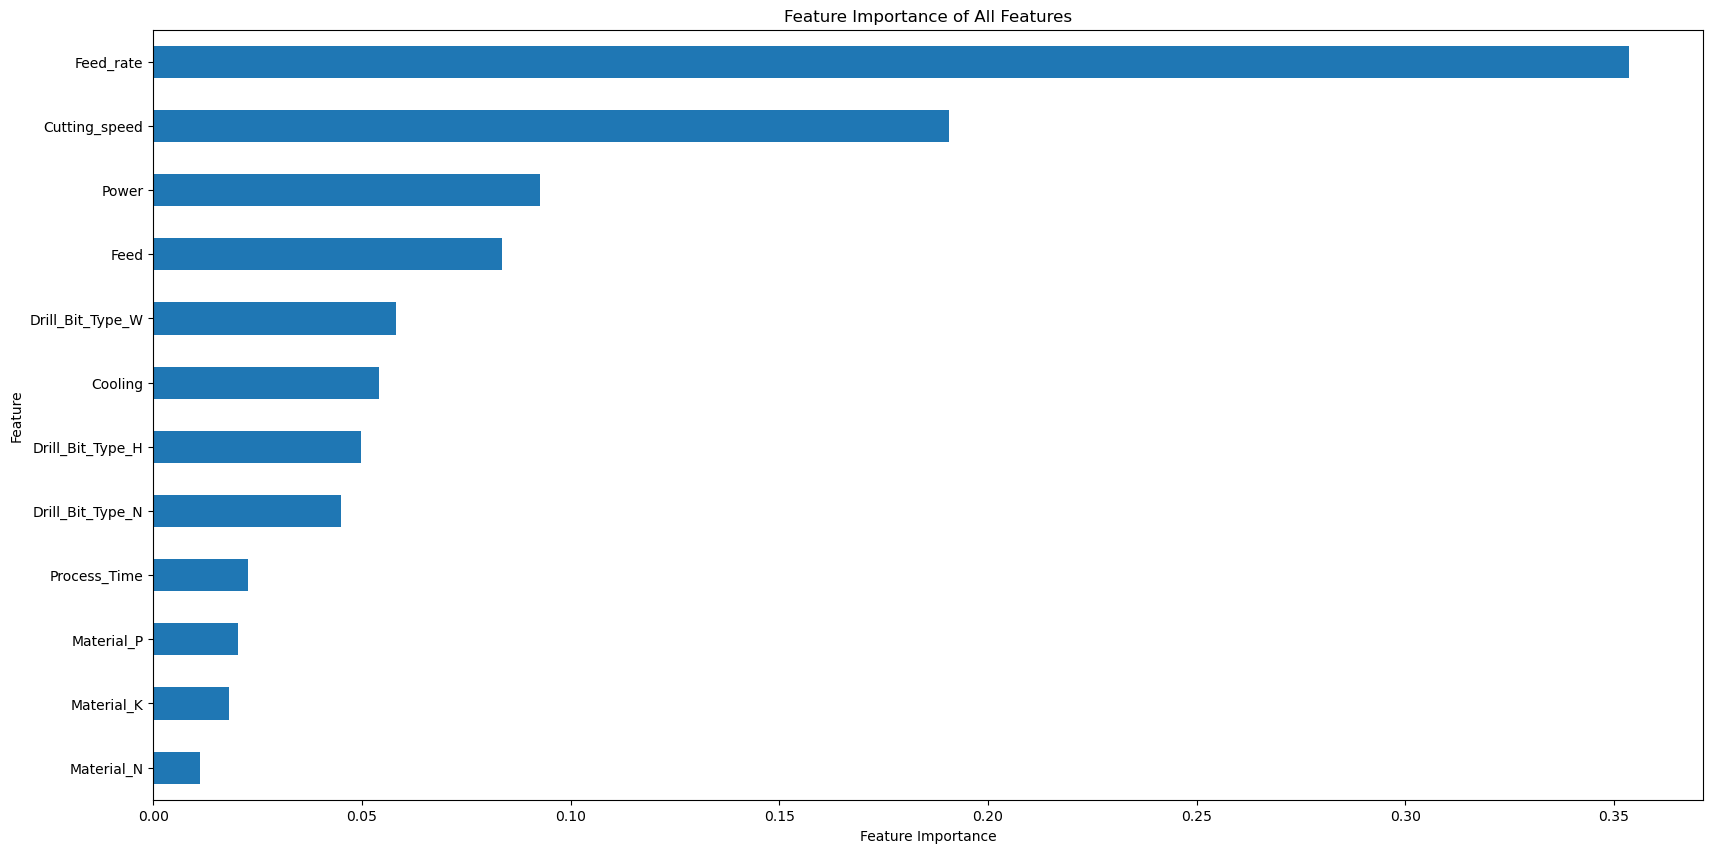

In [78]:
# Extract and sort feature importances
importances = pd.Series(rf.feature_importances_, index=['Cutting_speed', 'Feed', 'Feed_rate', 'Power',
                                                           'Cooling', 'Process_Time', 'Material_K', 'Material_N', 'Material_P',
                                                           'Drill_Bit_Type_H', 'Drill_Bit_Type_N', 'Drill_Bit_Type_W'])
importances = importances.sort_values(ascending=True)

# Plot feature importances
importances.plot(kind='barh', figsize=(20, 10))
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of All Features')
plt.grid(False)  # Disable grid lines
plt.show()

In [79]:
# List of feature names
feature_names = ['Cutting_speed', 'Feed', 'Feed_rate', 'Power',
                  'Cooling', 'Process_Time', 'Material_K', 'Material_N', 'Material_P',
                  'Drill_Bit_Type_H', 'Drill_Bit_Type_N', 'Drill_Bit_Type_W']

# Calculate permutation importance
perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)

# Create a DataFrame for permutation importances
perm_feat_imp = pd.DataFrame({
    'feature': feature_names,
    'mean': perm_importance.importances_mean,
    'std': perm_importance.importances_std
})

# Sort by mean importance
perm_feat_imp.sort_values('mean', inplace=True, ascending=False)

# Display the top features
perm_feat_imp.head(14)

,feature,mean,std
9,Drill_Bit_Type_H,0.348233,0.006309
11,Drill_Bit_Type_W,0.232667,0.004851
10,Drill_Bit_Type_N,0.192117,0.003502
2,Feed_rate,0.109000,0.001713
0,Cutting_speed,0.042100,0.001592
4,Cooling,0.013767,0.001160
1,Feed,0.003033,0.000795
3,Power,0.000133,0.000100
7,Material_N,0.000100,0.000082
6,Material_K,0.000067,0.000082


### Balanced dataset

Gini on train = 100.0
Gini on test = 99.8


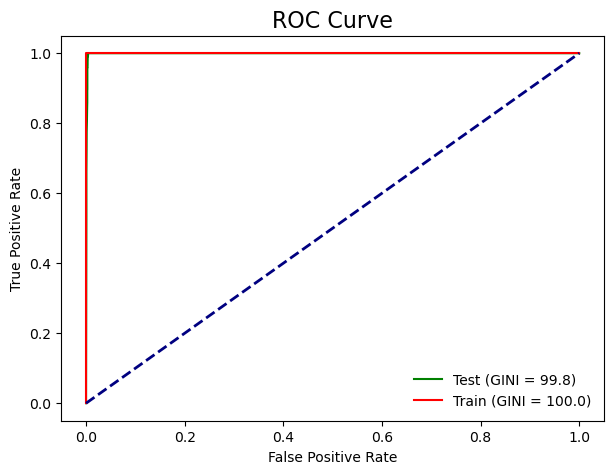

In [80]:
# Initialize the RandomForestClassifier
rfmodel = RandomForestClassifier(random_state=42, n_estimators=100)  # Adjust parameters as needed
rfmodel.fit(X_resampled_b, y_resampled_b)

# Compute the Gini coefficients
train_gini, _, _ = gini(y_resampled_b, rfmodel.predict_proba(X_resampled_b)[:,1], 'train')
test_gini, _, _ = gini(y_test, rfmodel.predict_proba(X_test)[:,1], 'test')

# Plot the Gini coefficients
plot_gini(y_resampled_b, rfmodel.predict_proba(X_resampled_b)[:,1], y_test, rfmodel.predict_proba(X_test)[:,1])

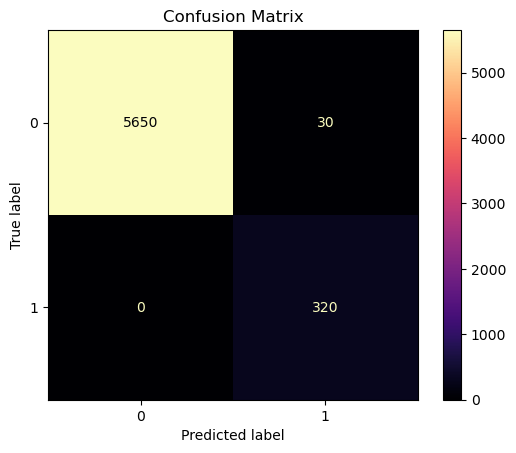

Test Classification Report:
                 precision    recall  f1-score   support

Machine Running       1.00      0.99      1.00      5680
 Machine Failed       0.91      1.00      0.96       320

       accuracy                           0.99      6000
      macro avg       0.96      1.00      0.98      6000
   weighted avg       1.00      0.99      1.00      6000



In [81]:
pred = rfmodel.predict(X_test)
ConfusionMatrixDisplay.from_predictions(
            y_test, pred,
            labels = rfmodel.classes_,
            cmap = 'magma')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print('Test Classification Report:')
print(classification_report(y_test, pred, target_names=['Machine Running', 'Machine Failed']))

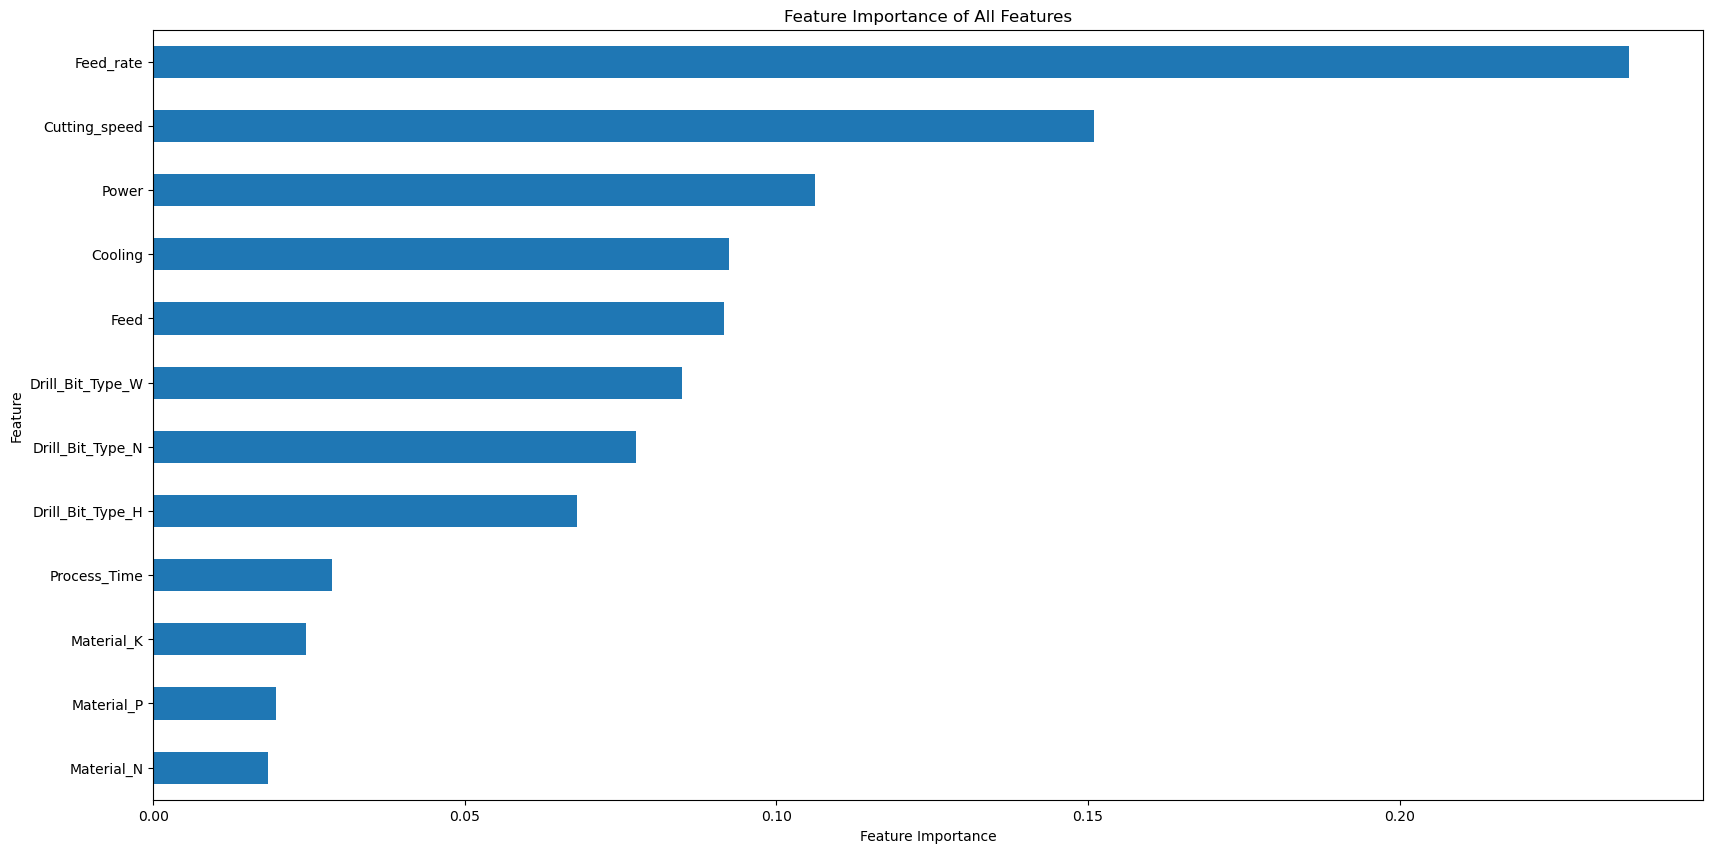

In [82]:
# Extract and sort feature importances
importances = pd.Series(rfmodel.feature_importances_, index=['Cutting_speed', 'Feed', 'Feed_rate', 'Power',
                                                           'Cooling', 'Process_Time', 'Material_K', 'Material_N', 'Material_P',
                                                           'Drill_Bit_Type_H', 'Drill_Bit_Type_N', 'Drill_Bit_Type_W'])
importances = importances.sort_values(ascending=True)

# Plot feature importances
importances.plot(kind='barh', figsize=(20, 10))
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of All Features')
plt.grid(False)  # Disable grid lines
plt.show()

In [83]:
# List of feature names
feature_names = ['Cutting_speed', 'Feed', 'Feed_rate', 'Power',
                  'Cooling', 'Process_Time', 'Material_K', 'Material_N', 'Material_P',
                  'Drill_Bit_Type_H', 'Drill_Bit_Type_N', 'Drill_Bit_Type_W']

# Calculate permutation importance
perm_importance = permutation_importance(rfmodel, X_test, y_test, n_repeats=10, random_state=42)

# Create a DataFrame for permutation importances
perm_feat_imp = pd.DataFrame({
    'feature': feature_names,
    'mean': perm_importance.importances_mean,
    'std': perm_importance.importances_std
})

# Sort by mean importance
perm_feat_imp.sort_values('mean', inplace=True, ascending=False)

# Display the top features
perm_feat_imp.head(14)

,feature,mean,std
9,Drill_Bit_Type_H,0.332667,0.005731
11,Drill_Bit_Type_W,0.300300,0.005621
10,Drill_Bit_Type_N,0.274833,0.004076
2,Feed_rate,0.125267,0.002997
0,Cutting_speed,0.040367,0.002129
4,Cooling,0.022500,0.001265
1,Feed,0.003167,0.000316
3,Power,0.000417,0.000271
8,Material_P,0.000383,0.000236
7,Material_N,0.000167,0.000075


### Hyperparameter Optimization Using RandomizedSearch

### Original dataset

In [84]:
# Define the parameter grid for RandomForestClassifier
param_grid = {
    'n_estimators': stats.randint(100, 300),       # Number of trees in the forest
    'max_depth': stats.randint(1, 10),            # Maximum depth of the tree
    'min_samples_split': stats.randint(2, 20),    # Minimum number of samples required to split an internal node
    'min_samples_leaf': stats.randint(1, 10),     # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],     # Number of features to consider at each split
    'bootstrap': [True, False],                   # Whether bootstrap samples are used when building trees
    'criterion': ['gini', 'entropy'],             # Function to measure the quality of a split
    'class_weight': [None, 'balanced', 'balanced_subsample'],  # Weights associated with classes
    'max_samples': stats.uniform(0.5, 1)          # Fraction of samples to draw from X to train each base estimator
}

In [85]:
# Set up the search with RandomizedSearchCV
search = RandomizedSearchCV(rf,
                            param_distributions=param_grid,
                            scoring='roc_auc',
                            cv=5,
                            n_iter=60,
                            random_state=42,
                            n_jobs=1,
                            refit=True)

In [86]:
# Find best hyperparameters
search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=60, n_jobs=1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': [None, 'balanced',
                                                         'balanced_subsample'],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002503DC006D0>,
                                        'max_features': ['auto', 'sqrt',
                                                         'lo...
                                        'max_samples': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002503CBE0E50>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002503D0B2790>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002503CC16E10>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002503DC0A290>},
                   random_state=42, scoring='roc_auc')

In [87]:
best_model = search.best_estimator_

Gini on train = 100.0
Gini on test = 99.7


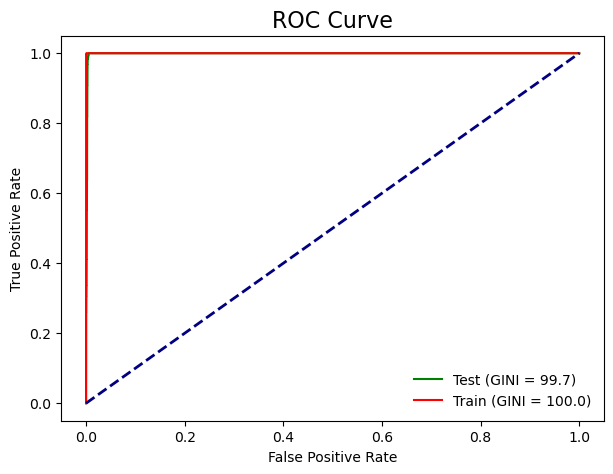

In [88]:
# Compute the Gini coefficients
train_gini, _, _ = gini(y_train, best_model.predict_proba(X_train)[:,1], 'train')
test_gini, _, _ = gini(y_test, best_model.predict_proba(X_test)[:,1], 'test')

# Plot the Gini coefficients
plot_gini(y_train, best_model.predict_proba(X_train)[:,1], y_test, best_model.predict_proba(X_test)[:,1])

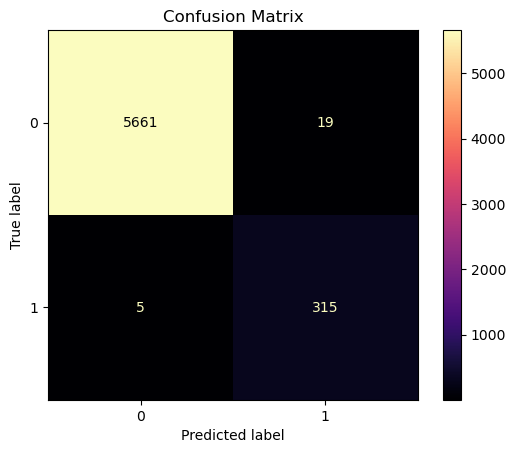

Test Classification Report:
                 precision    recall  f1-score   support

Machine Running       1.00      1.00      1.00      5680
 Machine Failed       0.94      0.98      0.96       320

       accuracy                           1.00      6000
      macro avg       0.97      0.99      0.98      6000
   weighted avg       1.00      1.00      1.00      6000



In [89]:
pred = best_model.predict(X_test)
ConfusionMatrixDisplay.from_predictions(
            y_test, pred,
            labels = best_model.classes_,
            cmap = 'magma')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print('Test Classification Report:')
print(classification_report(y_test, pred, target_names=['Machine Running', 'Machine Failed']))

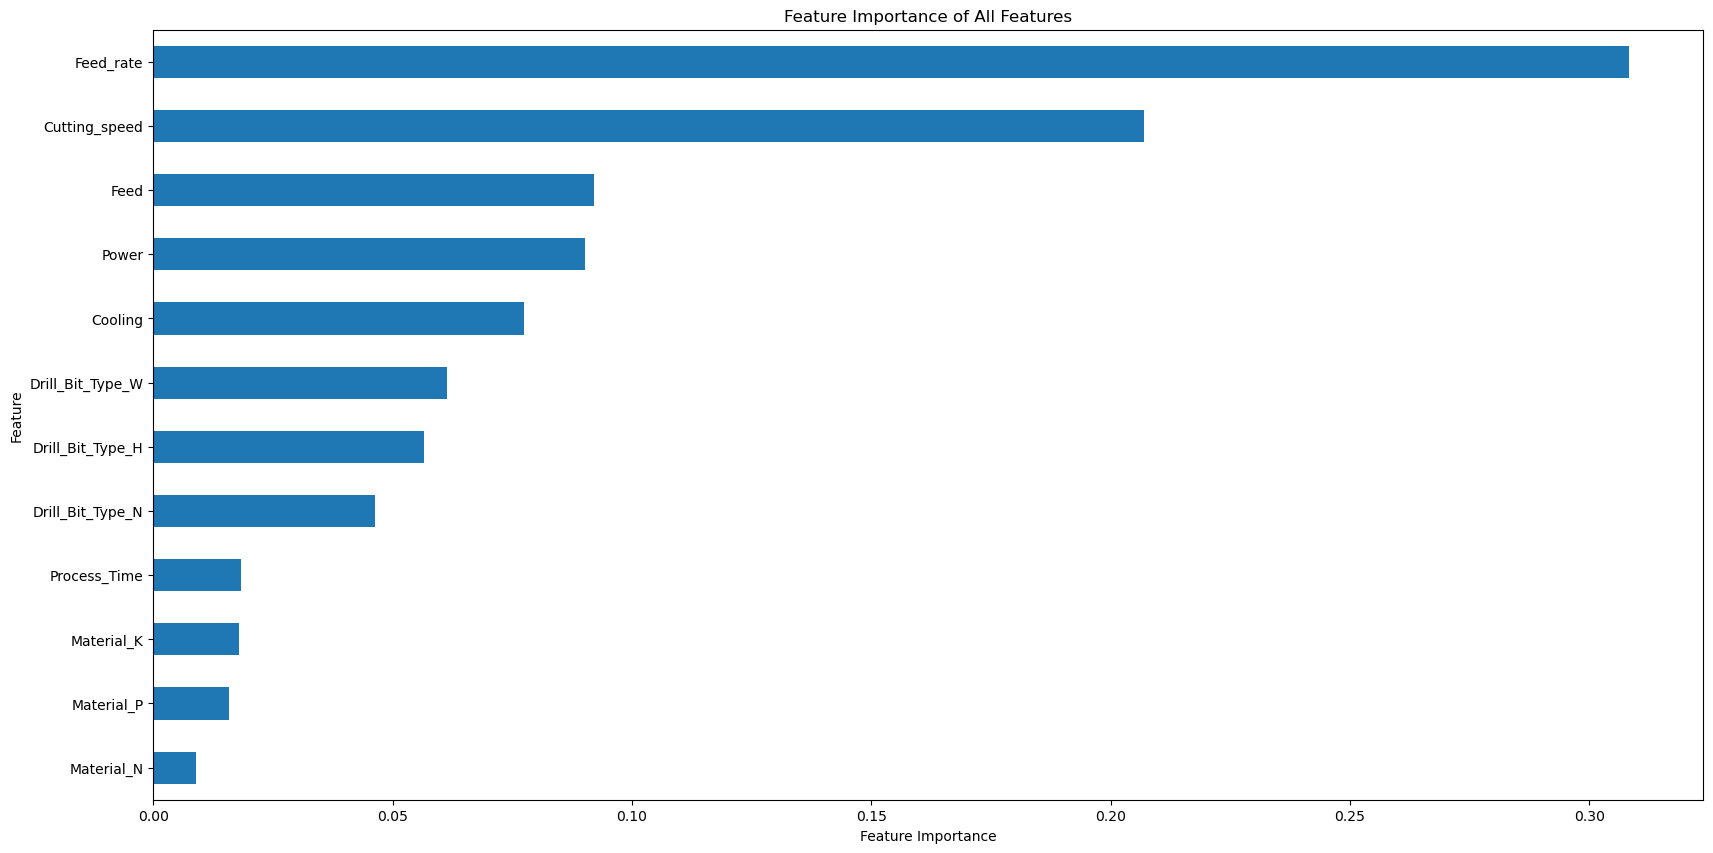

In [90]:
# Extract and sort feature importances
importances = pd.Series(best_model.feature_importances_, index=['Cutting_speed', 'Feed', 'Feed_rate', 'Power',
                                                           'Cooling', 'Process_Time', 'Material_K', 'Material_N', 'Material_P',
                                                           'Drill_Bit_Type_H', 'Drill_Bit_Type_N', 'Drill_Bit_Type_W'])
importances = importances.sort_values(ascending=True)

# Plot feature importances
importances.plot(kind='barh', figsize=(20, 10))
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of All Features')
plt.grid(False)  # Disable grid lines
plt.show()

In [91]:
# List of feature names
feature_names = ['Cutting_speed', 'Feed', 'Feed_rate', 'Power',
                  'Cooling', 'Process_Time', 'Material_K', 'Material_N', 'Material_P',
                  'Drill_Bit_Type_H', 'Drill_Bit_Type_N', 'Drill_Bit_Type_W']

# Calculate permutation importance
perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)

# Create a DataFrame for permutation importances
perm_feat_imp = pd.DataFrame({
    'feature': feature_names,
    'mean': perm_importance.importances_mean,
    'std': perm_importance.importances_std
})

# Sort by mean importance
perm_feat_imp.sort_values('mean', inplace=True, ascending=False)

# Display the top features
perm_feat_imp.head(14)

,feature,mean,std
2,Feed_rate,0.107183,0.001927
9,Drill_Bit_Type_H,0.048517,0.002259
0,Cutting_speed,0.039733,0.001578
11,Drill_Bit_Type_W,0.018217,0.000913
4,Cooling,0.010133,0.000718
10,Drill_Bit_Type_N,0.005217,0.000428
1,Feed,0.004017,0.000540
5,Process_Time,0.000450,0.000224
8,Material_P,0.000400,0.000200
3,Power,0.000233,0.000186


### Balanced data

In [92]:
# Set up the search with RandomizedSearchCV
Bsearch = RandomizedSearchCV(rfmodel,
                            param_distributions=param_grid,
                            scoring='roc_auc',
                            cv=5,
                            n_iter=30,
                            random_state=42,
                            n_jobs=1,
                            refit=True)

In [93]:
# Find best hyperparameters
Bsearch.fit(X_resampled_b, y_resampled_b)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=30, n_jobs=1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': [None, 'balanced',
                                                         'balanced_subsample'],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002503DC006D0>,
                                        'max_features': ['auto', 'sqrt',
                                                         'lo...
                                        'max_samples': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002503CBE0E50>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002503D0B2790>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002503CC16E10>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002503DC0A290>},
                   random_state=42, scoring='roc_auc')

In [94]:
# best model
best_model = Bsearch.best_estimator_

Gini on train = 100.0
Gini on test = 99.7


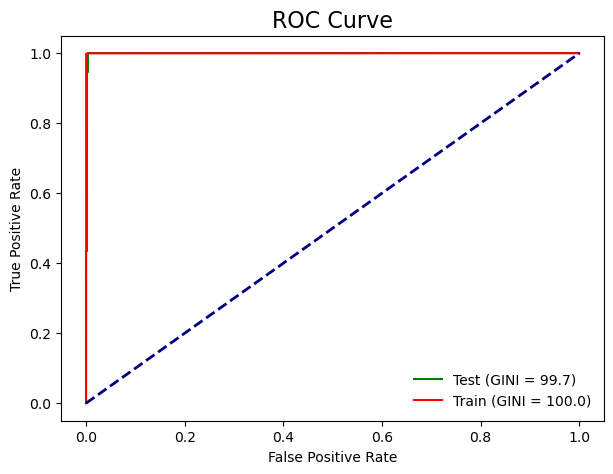

In [95]:
# Compute the Gini coefficients
train_gini, _, _ = gini(y_resampled_b, best_model.predict_proba(X_resampled_b)[:,1], 'train')
test_gini, _, _ = gini(y_test, best_model.predict_proba(X_test)[:,1], 'test')

# Plot the Gini coefficients
plot_gini(y_resampled_b, best_model.predict_proba(X_resampled_b)[:,1], y_test, best_model.predict_proba(X_test)[:,1])

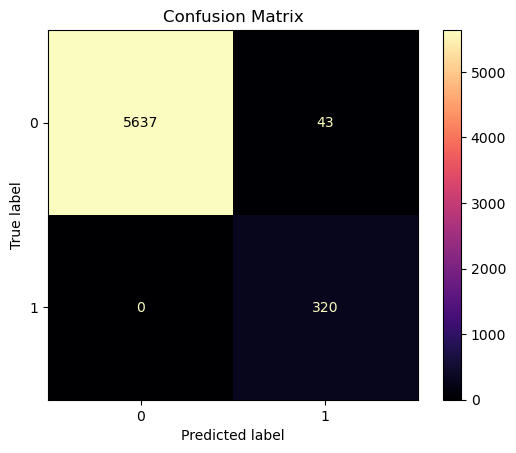

Test Classification Report:
                 precision    recall  f1-score   support

Machine Running       1.00      0.99      1.00      5680
 Machine Failed       0.88      1.00      0.94       320

       accuracy                           0.99      6000
      macro avg       0.94      1.00      0.97      6000
   weighted avg       0.99      0.99      0.99      6000



In [96]:
pred = best_model.predict(X_test)
ConfusionMatrixDisplay.from_predictions(
            y_test, pred,
            labels = best_model.classes_,
            cmap = 'magma')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print('Test Classification Report:')
print(classification_report(y_test, pred, target_names=['Machine Running', 'Machine Failed']))

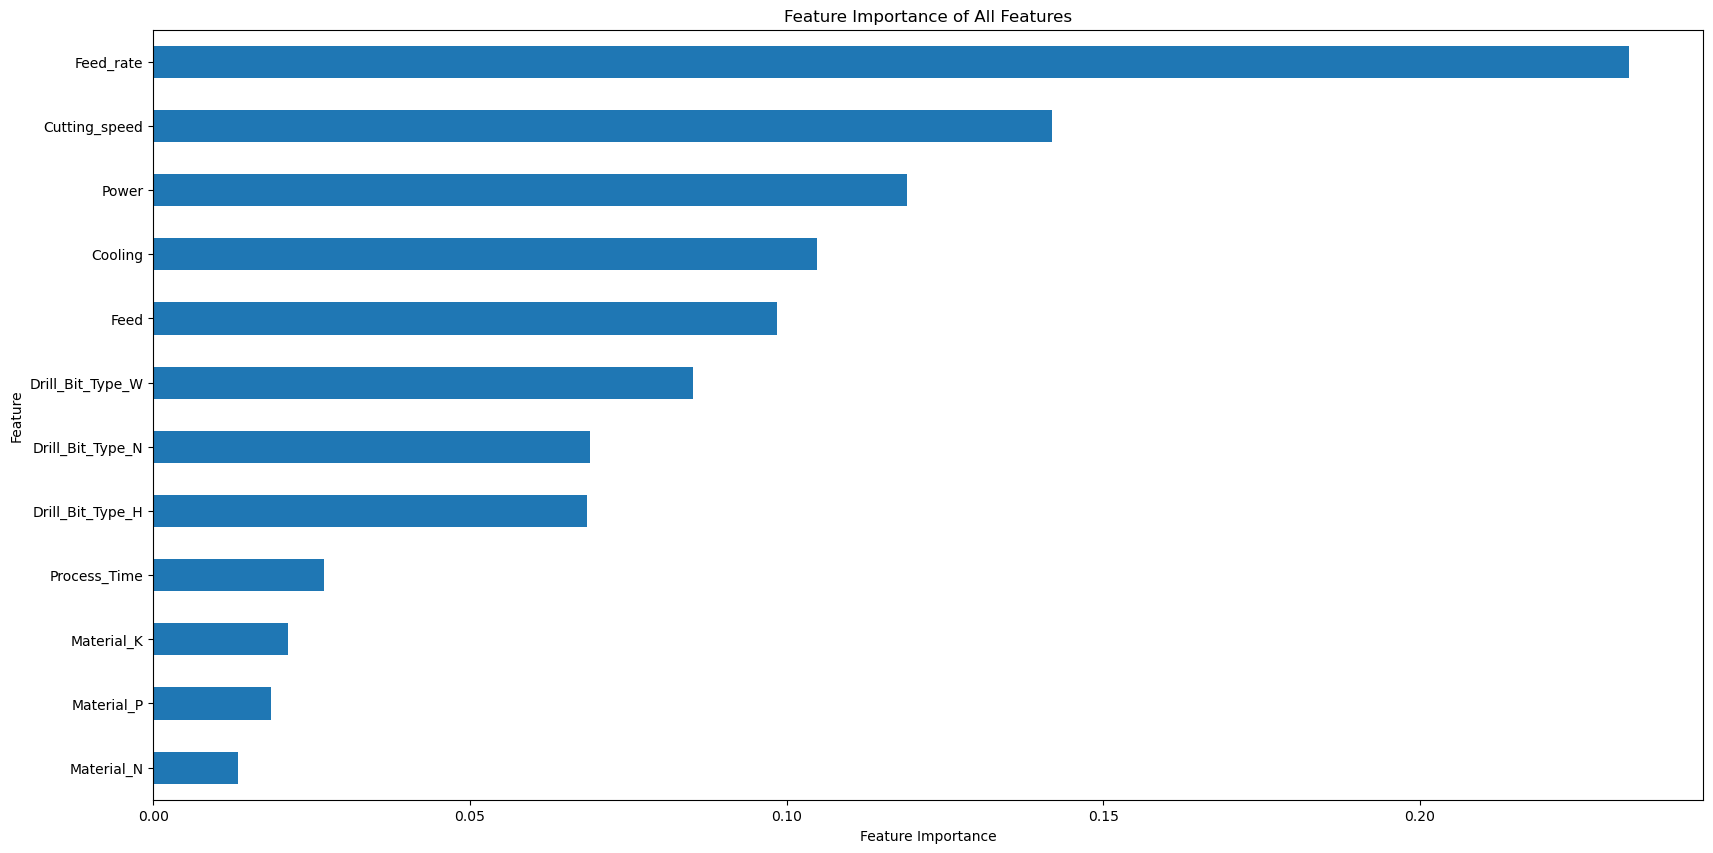

In [97]:
# Extract and sort feature importances
importances = pd.Series(best_model.feature_importances_, index=['Cutting_speed', 'Feed', 'Feed_rate', 'Power',
                                                           'Cooling', 'Process_Time', 'Material_K', 'Material_N', 'Material_P',
                                                           'Drill_Bit_Type_H', 'Drill_Bit_Type_N', 'Drill_Bit_Type_W'])
importances = importances.sort_values(ascending=True)

# Plot feature importances
importances.plot(kind='barh', figsize=(20, 10))
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of All Features')
plt.grid(False)  # Disable grid lines
plt.show()

In [98]:
# List of feature names
feature_names = ['Cutting_speed', 'Feed', 'Feed_rate', 'Power',
                  'Cooling', 'Process_Time', 'Material_K', 'Material_N', 'Material_P',
                  'Drill_Bit_Type_H', 'Drill_Bit_Type_N', 'Drill_Bit_Type_W']

# Calculate permutation importance
perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)

# Create a DataFrame for permutation importances
perm_feat_imp = pd.DataFrame({
    'feature': feature_names,
    'mean': perm_importance.importances_mean,
    'std': perm_importance.importances_std
})

# Sort by mean importance
perm_feat_imp.sort_values('mean', inplace=True, ascending=False)

# Display the top features
perm_feat_imp.head(14)

,feature,mean,std
11,Drill_Bit_Type_W,0.215217,0.004628
9,Drill_Bit_Type_H,0.203900,0.003100
10,Drill_Bit_Type_N,0.187950,0.002585
2,Feed_rate,0.141783,0.002294
0,Cutting_speed,0.040067,0.001657
4,Cooling,0.016450,0.001665
1,Feed,0.004000,0.000573
6,Material_K,0.002467,0.000245
8,Material_P,0.001783,0.000183
7,Material_N,0.000033,0.000067


In [99]:
import pickle
file = open('PM_random_forest_model.pkl','wb')
pickle.dump(best_model, file)
file.close()

In [100]:
import distutils
print("distutils is available")


distutils is available
